In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Feature Engineering
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score


# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc

# Please pass your API key here
# pc.settings.set_subscription_key('********************')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
from scipy import signal
from scipy import stats

In [2]:
#conda install tensorflow

In [3]:
crop_yield_data = pd.read_csv("Crop_Yield_Data_challenge_2.csv")
crop_yield_data.head()

,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Rice Yield (kg/ha)
0,Chau_Phu,10.510542,105.248554,SA,T,15-07-2022,3.40,5500
1,Chau_Phu,10.509150,105.265098,SA,T,15-07-2022,2.43,6000
2,Chau_Phu,10.467721,105.192464,SA,D,15-07-2022,1.95,6400
3,Chau_Phu,10.494453,105.241281,SA,T,15-07-2022,4.30,6000
4,Chau_Phu,10.535058,105.252744,SA,D,14-07-2022,3.30,6400


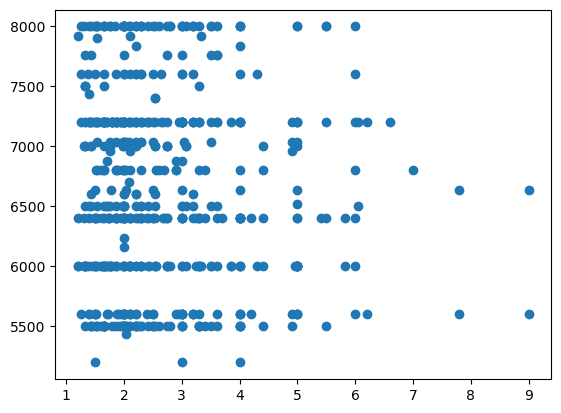

In [4]:
plt.scatter(crop_yield_data['Field size (ha)'], crop_yield_data['Rice Yield (kg/ha)'])
plt.show()

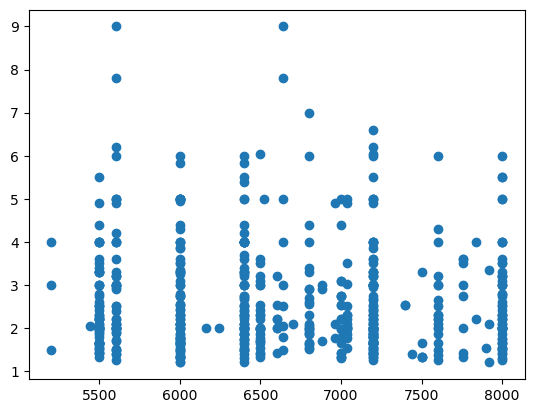

In [5]:
plt.scatter(crop_yield_data['Rice Yield (kg/ha)'], crop_yield_data['Field size (ha)'])
plt.show()

In [6]:
crop_yield_data.shape

(557, 8)

In [7]:
SA = crop_yield_data[crop_yield_data['Season(SA = Summer Autumn, WS = Winter Spring)'] == 'SA']

In [8]:
SA.head()

,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Rice Yield (kg/ha)
0,Chau_Phu,10.510542,105.248554,SA,T,15-07-2022,3.40,5500
1,Chau_Phu,10.509150,105.265098,SA,T,15-07-2022,2.43,6000
2,Chau_Phu,10.467721,105.192464,SA,D,15-07-2022,1.95,6400
3,Chau_Phu,10.494453,105.241281,SA,T,15-07-2022,4.30,6000
4,Chau_Phu,10.535058,105.252744,SA,D,14-07-2022,3.30,6400


In [9]:
SA.shape

(257, 8)

In [10]:
SA['Date of Harvest'].max()

'28-07-2022'

In [11]:
SA['Date of Harvest'].min()

'04-08-2022'

In [12]:
WS = crop_yield_data[crop_yield_data['Season(SA = Summer Autumn, WS = Winter Spring)'] == 'WS']

In [13]:
WS.shape

(300, 8)

In [14]:
WS['Date of Harvest'].max()

'28-03-2022'

In [15]:
WS['Date of Harvest'].min()

'01-04-2022'

In [16]:
def get_sentinel_data(longitude, latitude, season,assets):
    
    '''
    Returns a list of VV,VH, VV/VH values for a given latitude and longitude over a given time period (based on the season)
    Attributes:
    longitude - Longitude
    latitude - Latitude
    season - The season for which band values need to be extracted.
    assets - A list of bands to be extracted
    
    '''
    
    bands_of_interest = assets
    if season == 'SA':
        time_slice = "2022-05-01/2022-08-31"
    if season == 'WS':
        time_slice = "2022-01-01/2022-04-30"
        
    vv_list = []
    vh_list = []
    vv_by_vh_list = []
    rvi_list = []
    evi_list = []
    savi_list = []
    msavi_list = []
    ndvi_list = []
    gci_list = []
    pri_list = []
    nrbi_list = []
    bpvi_list = []
    
    bbox_of_interest = [longitude , latitude, longitude, latitude]
    time_of_interest = time_slice
    
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest)
    items = list(search.get_all_items())
    item = items[0]
    items.reverse()
    
    data = stac_load([items[1]],bands=bands_of_interest, patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)

    for item in items:
        data = stac_load([item], bands=bands_of_interest, patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)
        if(data['vv'].values[0][0]!=-32768.0 and data['vh'].values[0][0]!=-32768.0):
            data = data.where(~data.isnull(), 0)
            vv = data["vv"].astype("float64")
            vh = data["vh"].astype("float64")
            vv_list.append(np.median(vv))
            vh_list.append(np.median(vh))
            vv_by_vh_list.append(np.median(vv)/np.median(vh))
            ######## Radar Vegetation Index
            rvi_list.append(np.sqrt(np.median(vh)) / (np.sqrt(np.median(vv)) + np.sqrt(np.median(vh))))
            ######## Enhanced Vegetation Index
            evi_list.append(2.5 * (np.median(vv) - np.median(vh)) / (np.median(vv) + (6 * np.median(vh)) - (7.5 * np.median(vv))))
            ######## Soil adjusted vegetation index
            savi_list.append(1.5 * (np.median(vh) - np.median(vv)) / (0.5 + np.median(vv) + np.median(vh)))
            ######## Modified Soil-Adjusted Vegetation Index
            msavi_list.append((2 * np.median(vv) + 1) - np.sqrt((2 * np.median(vv) + 1) ** 2 - 8 * ((np.median(vv) - np.median(vh)))) / 2)                 
            ######## Normalized Difference Vegetation Index
            ndvi_list.append((np.median(vv) - np.median(vh)) / (np.median(vv) + np.median(vh)))
            ######## Green Chlorophyll Index
            gci_list.append(10 * (np.median(vv) - np.median(vh)) / (np.median(vv) + np.median(vh)))
            ######## Polarization Ratio Index
            pri_list.append((np.median(vh) - np.median(vv)) / (np.median(vh) + np.median(vv)))
            ######## Normalized Radar Backscatter Index
            nrbi_list.append((np.log(np.median(vv)) - np.log(np.median(vh))) / (np.log(np.median(vv)) + np.log(np.median(vh))))
            ######## Backscatter-based Perpendicular Vegetation Index
            bpvi_list.append(((np.sqrt(2 * (np.median(vv)**2 + np.median(vh)**2))) / np.median(vh)) - 1)
            

            
            
                        #vh_by_vv_list.append(np.median(vh)/np.median(vv))
                        #log_vh_by_vv_list.append(np.log(np.median(vh)/np.median(vv)))
                        #vv_vh_list.append(np.median(vv) * np.median(vh))
                        #sum_vv_vh_list.append(np.median(vv) + np.median(vh))
                        #sub_vv_vh_list.append(np.median(vv) - np.median(vh))
                        #nl_list.append((np.median(vv) * np.median(vh)) / (np.median(vv) + np.median(vh)))
                        #rgi_list.append((np.median(vv) - np.median(vh)) / (np.median(vv) + np.median(vh)))
                        #dpdd_list.append((np.median(vv) + np.median(vh)) / np.sqrt(2))
                        #dpsvi_list.append((np.median(vv) * np.median(vv)) + (np.median(vv) * np.median(vh)) / np.sqrt(2))
                        #nrpb_list.append((np.median(vh) - np.median(vv)) / (np.median(vh) + np.median(vv)))
                        #avg_vv_vh_list.append((np.median(vv) + np.median(vh)) / 2)
                        #cohvv = calculateCoherenceMatrix(np.median(vv))

                            
    return vv_list, vh_list, vv_by_vh_list, rvi_list, evi_list, savi_list, msavi_list, ndvi_list, gci_list, pri_list, nrbi_list, bpvi_list

In [17]:
## Get Sentinel-1-RTC Data
assets = ['vv','vh']
train_band_values=crop_yield_data.progress_apply(lambda x: get_sentinel_data(x['Longitude'], x['Latitude'],x['Season(SA = Summer Autumn, WS = Winter Spring)'], assets), axis = 1)
vv = [x[0] for x in train_band_values]
vh = [x[1] for x in train_band_values]
vv_by_vh = [x[2] for x in train_band_values]
rvi = [x[3] for x in train_band_values]
evi = [x[4] for x in train_band_values]
savi = [x[5] for x in train_band_values]
msavi = [x[6] for x in train_band_values]
ndvi = [x[7] for x in train_band_values]
gci = [x[8] for x in train_band_values]
pri = [x[9] for x in train_band_values]
nrbi = [x[10] for x in train_band_values]
bpvi = [x[11] for x in train_band_values]

#vv_vv = [x[12] for x in train_band_values]
#vh_vh = [x[13] for x in train_band_values]
#vh_vv = [x[14] for x in train_band_values]
#nrvi = [x[15] for x in train_band_values]
#vddp = [x[16] for x in train_band_values]
#dpdd = [x[17] for x in train_band_values]
#dpsvi = [x[18] for x in train_band_values]
#nrpb = [x[19] for x in train_band_values]
#avg_vv_vh = [x[20] for x in train_band_values]
#cohvv = [x[21] for x in train_band_values]

vv_vh_data = pd.DataFrame(list(zip(vv, vh, vv_by_vh, rvi, evi, savi, msavi, ndvi, gci, pri, nrbi, bpvi)), 
        columns = ["vv_list", "vh_list", "vv/vh_list", "rvi_list", "evi_list", "savi_list", "msavi_list", "ndvi_list", "gci_list", "pri_list", "nrbi_list", "bpvi_list"])

  0%|          | 0/557 [00:00<?, ?it/s]

In [18]:
def ordinal_distribution(data, dx=3, dy=1, taux=1, tauy=1, return_missing=False, tie_precision=None):
    '''
    Returns
    -------
     : tuple
       Tuple containing two arrays, one with the ordinal patterns occurring in data 
       and another with their corresponding probabilities.
       
    Attributes
    ---------
    data : array 
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`.
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    dy : int
         Embedding dimension (vertical axis); it must be 1 for time series 
         (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).
    return_missing: boolean
                    If `True`, it returns ordinal patterns not appearing in the 
                    symbolic sequence obtained from **data** are shown. If `False`,
                    these missing patterns (permutations) are omitted 
                    (default: `False`).
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
   
    '''
    def setdiff(a, b):
        '''
        Returns
        -------
        : array
            An array containing the elements in `a` that are not contained in `b`.
            
        Parameters
        ----------    
        a : tuples, lists or arrays
            Array in the format :math:`[[x_{21}, x_{22}, x_{23}, \\ldots, x_{2m}], 
            \\ldots, [x_{n1}, x_{n2}, x_{n3}, ..., x_{nm}]]`.
        b : tuples, lists or arrays
            Array in the format :math:`[[x_{21}, x_{22}, x_{23}, \\ldots, x_{2m}], 
            \\ldots, [x_{n1}, x_{n2}, x_{n3}, ..., x_{nm}]]`.
        '''

        a = np.asarray(a).astype('int64')
        b = np.asarray(b).astype('int64')

        _, ncols = a.shape

        dtype={'names':['f{}'.format(i) for i in range(ncols)],
            'formats':ncols * [a.dtype]}

        C = np.setdiff1d(a.view(dtype), b.view(dtype))
        C = C.view(a.dtype).reshape(-1, ncols)

        return(C)

    try:
        ny, nx = np.shape(data)
        data   = np.array(data)
    except:
        nx     = np.shape(data)[0]
        ny     = 1
        data   = np.array([data])

    if tie_precision is not None:
        data = np.round(data, tie_precision)

    partitions = np.concatenate(
        [
            [np.concatenate(data[j:j+dy*tauy:tauy,i:i+dx*taux:taux]) for i in range(nx-(dx-1)*taux)] 
            for j in range(ny-(dy-1)*tauy)
        ]
    )

    symbols = np.apply_along_axis(np.argsort, 1, partitions)
    symbols, symbols_count = np.unique(symbols, return_counts=True, axis=0)

    probabilities = symbols_count/len(partitions)

    if return_missing==False:
        return symbols, probabilities
    
    else:
        all_symbols   = list(map(list,list(itertools.permutations(np.arange(dx*dy)))))
        miss_symbols  = setdiff(all_symbols, symbols)
        symbols       = np.concatenate((symbols, miss_symbols))
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols.__len__())))
        
        return symbols, probabilities

In [19]:
def permutation_entropy(data, dx=3, dy=1, taux=1, tauy=1, base=2, normalized=True, probs=False, tie_precision=None):
    '''
    Returns Permutation Entropy
    Attributes:
    data : array
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`
           or an ordinal probability distribution (such as the ones returned by :func:`ordpy.ordinal_distribution`).
    dx :   int
           Embedding dimension (horizontal axis) (default: 3).
    dy :   int
           Embedding dimension (vertical axis); it must be 1 for time series (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 2).
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value 
                (default: `True`). If `False`, it is not.
    probs : boolean
            If `True`, assumes **data** is an ordinal probability distribution. If 
            `False`, **data** is expected to be a one- or two-dimensional 
            array (default: `False`). 
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
    '''
    if not probs:
        _, probabilities = ordinal_distribution(data, dx, dy, taux, tauy, return_missing=False, tie_precision=tie_precision)
    else:
        probabilities = np.asarray(data)
        probabilities = probabilities[probabilities>0]

    if normalized==True and base in [2, '2']:        
        smax = np.log2(float(np.math.factorial(dx*dy)))
        s    = -np.sum(probabilities*np.log2(probabilities))
        return s/smax
         
    elif normalized==True and base=='e':        
        smax = np.log(float(np.math.factorial(dx*dy)))
        s    = -np.sum(probabilities*np.log(probabilities))
        return s/smax
    
    elif normalized==False and base in [2, '2']:
        return -np.sum(probabilities*np.log2(probabilities))
    else:
        return -np.sum(probabilities*np.log(probabilities))

In [20]:
def generate_stastical_features(dataframe):
    '''
    Returns a  list of statistical features such as min,max,range,mean,auto-correlation,permutation entropy for each of the features
    Attributes:
    dataframe - DataFrame consisting of VV,VH and VV/VH for a time period
    '''
    features_list = []
    for index, row in dataframe.iterrows():
        min_vv = min(row[0])
        max_vv = max(row[0])
        range_vv = max_vv - min_vv
        mean_vv = np.mean(row[0])
        std_vv = np.std(row[0])
        var_vv = np.var(row[0])
        correlation_vv = sm.tsa.acf(row[0])[1]
        permutation_entropy_vv = permutation_entropy(row[0], dx=6,base=2, normalized=True)
        sk_vv = stats.skew(row[0])
        kr_vv = stats.kurtosis(row[0])
        corr_vv = np.corrcoef(row[0])
        vrt_vv = stats.variation(row[0])
        #gmean_vv = stats.mstats.gmean(row[0])
        #hmean_vv = stats.hmean(row[0])
        #sin_vv = np.sin(row[0])
        #cos_vv = np.cos(row[0])
        #ft_vv = np.fft.fft(row[0]) 


        min_vh = min(row[1])
        max_vh = max(row[1])
        range_vh = max_vh - min_vh
        mean_vh = np.mean(row[1])
        std_vh = np.std(row[1])
        var_vh = np.var(row[1])
        correlation_vh = sm.tsa.acf(row[1])[1]
        permutation_entropy_vh = permutation_entropy(row[1], dx=6, base=2, normalized=True)
        sk_vh = stats.skew(row[1])
        kr_vh = stats.kurtosis(row[1])
        corr_vh = np.corrcoef(row[1])
        vrt_vh = stats.variation(row[1])
        #gmean_vh = stats.mstats.gmean(row[1])
        #hmean_vh = stats.hmean(row[1])
        #sin_vh = np.sin(row[1])
        #cos_vh = np.cos(row[1])
        #ft_vh = np.fft.fft(row[1])
    
        min_vv_by_vh = min(row[2])
        max_vv_by_vh = max(row[2])
        range_vv_by_vh = max_vv_by_vh - min_vv_by_vh
        mean_vv_by_vh = np.mean(row[2])
        std_vv_by_vh = np.std(row[2])
        var_vv_by_vh = np.var(row[2])
        correlation_vv_by_vh = sm.tsa.acf(row[2])[1]
        permutation_entropy_vv_by_vh = permutation_entropy(row[2], dx=6, base=2, normalized=True)
        sk_vv_by_vh = stats.skew(row[2])
        kr_vv_by_vh = stats.kurtosis(row[2])
        corr_vv_by_vh = np.corrcoef(row[2])
        vrt_vv_by_vh = stats.variation(row[2])
        #gmean_vv_by_vh = stats.mstats.gmean(row[2])
        #hmean_vv_by_vh = stats.hmean(row[2])
        #sin_vv_by_vh = np.sin(row[2])
        #cos_vv_by_vh = np.cos(row[2])
        #ft_vv_by_vh = np.fft.fft(row[2])
        
        min_rvi = min(row[3])
        max_rvi = max(row[3])
        range_rvi = max_rvi - min_rvi
        mean_rvi = np.mean(row[3])
        std_rvi = np.std(row[3])
        var_rvi = np.var(row[3])
        correlation_rvi = sm.tsa.acf(row[3])[1]
        permutation_entropy_rvi = permutation_entropy(row[3], dx=6, base=2, normalized=True)
        sk_rvi = stats.skew(row[3])
        kr_rvi = stats.kurtosis(row[3])
        corr_rvi = np.corrcoef(row[3])
        vrt_rvi = stats.variation(row[3])
        #gmean_log_vv_by_vh =  stats.mstats.gmean(row[3])
        #hmean_log_vv_by_vh = stats.hmean(row[3])
        #sin_log_vv_by_vh = np.sin(row[3])
        #cos_log_vv_by_vh = np.cos(row[3])
        #ft_log_vv_by_vh = np.fft.fft(row[3])
        
        min_evi = min(row[4])
        max_evi = max(row[4])
        range_evi = max_evi - min_evi
        mean_evi = np.mean(row[4])
        std_evi = np.std(row[4])
        var_evi = np.var(row[4])
        correlation_evi = sm.tsa.acf(row[4])[1]
        permutation_entropy_evi = permutation_entropy(row[4], dx=6, base=2, normalized=True)
        sk_evi = stats.skew(row[4])
        kr_evi = stats.kurtosis(row[4])
        corr_evi = np.corrcoef(row[4])
        vrt_evi = stats.variation(row[4])
        #gmean_vh_by_vv = stats.mstats.gmean(row[4])
        #hmean_vh_by_vv = stats.hmean(row[4])
        #sin_vh_by_vv = np.sin(row[4])
        #cos_vh_by_vv = np.cos(row[4])
        #ft_vh_by_vv = np.fft.fft(row[4])
        
        min_savi = min(row[5])
        max_savi = max(row[5])
        range_savi = max_savi - min_savi
        mean_savi = np.mean(row[5])
        std_savi = np.std(row[5])
        var_savi = np.var(row[5])
        correlation_savi = sm.tsa.acf(row[5])[1]
        permutation_entropy_savi = permutation_entropy(row[5], dx=6, base=2, normalized=True)
        sk_savi = stats.skew(row[5])
        kr_savi = stats.kurtosis(row[5])
        corr_savi = np.corrcoef(row[5])
        vrt_savi = stats.variation(row[5])
        #gmean_log_vh_by_vv = stats.mstats.gmean(row[5])
        #hmean_log_vh_by_vv = stats.hmean(row[5])
        #sin_log_vh_by_vv = np.sin(row[5])
        #cos_log_vh_by_vv = np.cos(row[5])
        #ft_log_vh_by_vv = np.fft.fft(row[5])
                
        min_msavi = min(row[6])
        max_msavi = max(row[6])
        range_msavi = max_msavi - min_msavi
        mean_msavi = np.mean(row[6])
        std_msavi = np.std(row[6])
        var_msavi = np.var(row[6])
        correlation_msavi = sm.tsa.acf(row[6])[1]
        permutation_entropy_msavi = permutation_entropy(row[6], dx=6, base=2, normalized=True)
        sk_msavi = stats.skew(row[6])
        kr_msavi = stats.kurtosis(row[6])
        corr_msavi = np.corrcoef(row[6])
        vrt_msavi = stats.variation(row[6])
        #gmean_vv_vh = stats.mstats.gmean(row[6])
        #hmean_vv_vh = stats.hmean(row[6])
        #sin_vv_vh = np.sin(row[6])
        #cos_vv_vh = np.cos(row[6])
        #ft_vv_vh = np.fft.fft(row[6])
                
        min_ndvi = min(row[7])
        max_ndvi = max(row[7])
        range_ndvi = max_ndvi - min_ndvi
        mean_ndvi = np.mean(row[7])
        std_ndvi = np.std(row[7])
        var_ndvi = np.var(row[7])
        correlation_ndvi = sm.tsa.acf(row[7])[1]
        permutation_entropy_ndvi = permutation_entropy(row[7], dx=6, base=2, normalized=True)
        sk_ndvi = stats.skew(row[7])
        kr_ndvi = stats.kurtosis(row[7])
        corr_ndvi = np.corrcoef(row[7])
        vrt_ndvi = stats.variation(row[7])
        #gmean_sum_vv_vh = stats.mstats.gmean(row[7])
        #hmean_sum_vv_vh = stats.hmean(row[7])
        #sin_sum_vv_vh = np.sin(row[7])
        #cos_sum_vv_vh = np.cos(row[7])
        #ft_sum_vv_vh = np.fft.fft(row[7])
        
        min_gci = min(row[8])
        max_gci = max(row[8])
        range_gci = max_gci - min_gci
        mean_gci = np.mean(row[8])
        std_gci = np.std(row[8])
        var_gci = np.var(row[8])
        correlation_gci = sm.tsa.acf(row[8])[1]
        permutation_entropy_gci = permutation_entropy(row[8], dx=6, base=2, normalized=True)
        sk_gci = stats.skew(row[8])
        kr_gci = stats.kurtosis(row[8])
        corr_gci = np.corrcoef(row[8])
        vrt_gci = stats.variation(row[8])
        #gmean_sub_vv_vh = stats.mstats.gmean(row[8])
        #hmean_sub_vv_vh = stats.hmean(row[8])
        #sin_sub_vv_vh = np.sin(row[8])
        #cos_sub_vv_vh = np.cos(row[8])
        #ft_sub_vv_vh = np.fft.fft(row[8])
                
        min_pri = min(row[9])
        max_pri = max(row[9])
        range_pri = max_pri - min_pri
        mean_pri = np.mean(row[9])
        std_pri = np.std(row[9])
        var_pri = np.var(row[9])
        correlation_pri = sm.tsa.acf(row[9])[1]
        permutation_entropy_pri = permutation_entropy(row[9], dx=6, base=2, normalized=True)
        sk_pri = stats.skew(row[9])
        kr_pri = stats.kurtosis(row[9])
        corr_pri = np.corrcoef(row[9])
        vrt_pri = stats.variation(row[9])
        #gmean_n1 = stats.mstats.gmean(row[9])
        #hmean_n1 = stats.hmean(row[9])
        #sin_n1 = np.sin(row[9])
        #cos_n1 = np.cos(row[9])
        #ft_n1 = np.fft.fft(row[9])
                
        min_nrbi = min(row[10])
        max_nrbi = max(row[10])
        range_nrbi = max_nrbi - min_nrbi
        mean_nrbi = np.mean(row[10])
        std_nrbi = np.std(row[10])
        var_nrbi = np.var(row[10])
        correlation_nrbi = sm.tsa.acf(row[10])[1]
        permutation_entropy_nrbi = permutation_entropy(row[10], dx=6, base=2, normalized=True)
        sk_nrbi = stats.skew(row[10])
        kr_nrbi = stats.kurtosis(row[10])
        corr_nrbi = np.corrcoef(row[10])
        vrt_nrbi = stats.variation(row[10])
        #gmean_rgi= stats.mstats.gmean(row[10])
        #hmean_rgi = stats.hmean(row[10])
        #sin_rgi = np.sin(row[10])
        #cos_rgi = np.cos(row[10])
        #ft_rgi = np.fft.fft(row[10])
                
        min_bpvi = min(row[11])
        max_bpvi = max(row[11])
        range_bpvi = max_bpvi - min_bpvi
        mean_bpvi = np.mean(row[11])
        std_bpvi = np.std(row[11])
        var_bpvi = np.var(row[11])
        correlation_bpvi = sm.tsa.acf(row[11])[1]
        permutation_entropy_bpvi = permutation_entropy(row[11], dx=6, base=2, normalized=True)
        sk_bpvi = stats.skew(row[11])
        kr_bpvi = stats.kurtosis(row[11])
        corr_bpvi = np.corrcoef(row[11])
        vrt_bpvi = stats.variation(row[11])
        #gmean_rvi= stats.mstats.gmean(row[11])
        #hmean_rvi = stats.hmean(row[11])
        #sin_rvi = np.sin(row[11])
        #cos_rvi = np.cos(row[11])
        #ft_rvi = np.fft.fft(row[11])
        
        
        #gmean_vv_vv = stats.mstats.gmean(row[12])
        #hmean_vv_vv = stats.hmean(row[12])
        #sin_vv_vv = np.sin(row[12])
        #cos_vv_vv = np.cos(row[12])
        #ft_vv_vv = np.fft.fft(row[12])
    
        features_list.append([min_vv, max_vv, range_vv, mean_vv, std_vv, var_vv, 
                              correlation_vv, permutation_entropy_vv,
                              sk_vv, kr_vv, vrt_vv, 
                              #gmean_vv, hmean_vv, #sin_vv, cos_vv, ft_vv, 
                          
                              min_vh, max_vh, range_vh,  mean_vh, std_vh, var_vh, 
                              correlation_vh, permutation_entropy_vh,
                              sk_vh, kr_vh, vrt_vh, 
                              #gmean_vh, hmean_vh, #sin_vh, cos_vh, ft_vh,
                          
                              min_vv_by_vh, max_vv_by_vh, range_vv_by_vh, mean_vv_by_vh, 
                              std_vv_by_vh, var_vv_by_vh, 
                              correlation_vv_by_vh, permutation_entropy_vv_by_vh, 
                              sk_vv_by_vh, kr_vv_by_vh, vrt_vv_by_vh, 
                              #gmean_vv_by_vh, hmean_vv_by_vh, #sin_vv_by_vh, cos_vv_by_vh, ft_vv_by_vh,
                              #min_log_vv_by_vh,  max_log_vv_by_vh, 
                        #range_log_vv_by_vh, mean_log_vv_by_vh, std_log_vv_by_vh, 
                        #var_log_vv_by_vh, correlation_log_vv_by_vh, sk_log_vv_by_vh, kr_log_vv_by_vh, 
                        #vrt_log_vv_by_vh,
                         #sin_vh_by_vv, cos_vh_by_vv, ft_vh_by_vv,
                        #min_log_vh_by_vv, max_log_vh_by_vv, range_log_vh_by_vv, 
                        #mean_log_vh_by_vv, std_log_vh_by_vv, var_log_vh_by_vv, correlation_log_vh_by_vv, 
                              #sk_log_vh_by_vv, kr_log_vh_by_vv, 
                        #vrt_log_vh_by_vv, #sin_vv_vh, cos_vv_vh, ft_vv_vh,  
                              
                        min_rvi, max_rvi, 
                       range_rvi, mean_rvi, std_rvi, var_rvi, 
                              correlation_rvi, permutation_entropy_rvi,
                         sk_rvi, kr_rvi, vrt_rvi, 
                              #gmean_sum_vv_vh, hmean_sum_vv_vh, #sin_sum_vv_vh, cos_sum_vv_vh, ft_sum_vv_vh,
                              
                        min_evi, max_evi, range_evi, mean_evi, std_evi, var_evi, 
                              correlation_evi, permutation_entropy_evi,
                    sk_evi, kr_evi, vrt_evi, 
                              #gmean_sub_vv_vh, #hmean_sub_vv_vh, 
                              #sin_sub_vv_vh, cos_sub_vv_vh, ft_sub_vv_vh,
                              
                        min_savi, max_savi, range_savi, mean_savi, std_savi, var_savi, 
                              correlation_savi, permutation_entropy_savi,
                              sk_savi, kr_savi, vrt_savi, 
                              #gmean_n1, hmean_n1, #sin_n1, cos_n1, ft_n1,
                              
                        min_msavi, max_msavi, range_msavi, mean_msavi, std_msavi, var_msavi, 
                              correlation_msavi, permutation_entropy_msavi,
                        sk_msavi, kr_msavi, vrt_msavi, 
                              #gmean_rgi, #hmean_rgi, 
                              #sin_rgi, cos_rgi, ft_rgi,
                              
                              min_ndvi, max_ndvi, 
                        range_ndvi, mean_ndvi, std_ndvi, var_ndvi, 
                              correlation_ndvi, permutation_entropy_ndvi,
                        sk_ndvi, kr_ndvi, vrt_ndvi, 
                              #gmean_ndvi, hmean_ndvi, #sin_rvi, cos_rvi, ft_rvi,   
                              
                              min_gci, max_gci, 
                        range_gci, mean_gci, std_gci, var_gci, 
                              correlation_gci, permutation_entropy_gci,
                                                      sk_gci, kr_gci, vrt_gci, 
                              #gmean_vv_vv, hmean_vv_vv, #sin_vv_vv, cos_vv_vv, ft_vv_vv,
                              
                              min_pri, max_pri, 
                        range_pri, mean_pri, std_pri, var_pri, 
                              correlation_pri, permutation_entropy_pri,
                                                      sk_pri, kr_pri, vrt_pri, 
                              #gmean_vh_vh, hmean_vh_vh, #sin_vh_vh, cos_vh_vh, ft_vh_vh,
                              
                              min_nrbi, max_nrbi, 
                        range_nrbi, mean_nrbi, std_nrbi, var_nrbi, 
                              correlation_nrbi, permutation_entropy_nrbi,
                                                      sk_nrbi, kr_nrbi, vrt_nrbi, 
                              #gmean_vh_vv, hmean_vh_vv, #sin_vh_vv, cos_vh_vv, ft_vh_vv,
                              
                              min_bpvi, max_bpvi, 
                        range_bpvi, mean_bpvi, std_bpvi, var_bpvi, 
                              correlation_bpvi, permutation_entropy_bpvi,
                                                      sk_bpvi, kr_bpvi, vrt_bpvi 
                              #gmean_nrvi, hmean_nrvi, #sin_nrvi, cos_nrvi, ft_nrvi,
])
        
    return features_list

In [21]:
# Generating Statistical Features for VV,VH and VV/VH and creating a dataframe
features = generate_stastical_features(vv_vh_data)
features_data = pd.DataFrame(features, columns = ['min_vv', 'max_vv', 'range_vv', 'mean_vv', 
                                                  'std_vv', 'var_vv', 
                                                  'correlation_vv', 'permutation_entropy_vv', 
                        'sk_vv', 'kr_vv', 'vrt_vv', 
                                                  #'gmean_vv', 'hmean_vv', #'sin_vv', 'cos_vv', 'ft_vv',
                                                  
                                                  'min_vh', 'max_vh', 'range_vh', 'mean_vh', 
                                            'std_vh', 'var_vh', 
                                                  'correlation_vh', 'permutation_entropy_vh',
                                                 'sk_vh', 'kr_vh', 'vrt_vh', 
                                                  #'gmean_vh', 'hmean_vh', #'sin_vh', 'cos_vh', 'ft_vh',
                                                  
                          'min_vv_by_vh',  'max_vv_by_vh', 'range_vv_by_vh', 'mean_vv_by_vh', 'std_vv_by_vh', 'var_vv_by_vh', 
                                                  'correlation_vv_by_vh', 'permutation_entropy_vv_by_vh', 'sk_vv_by_vh', 'kr_vv_by_vh', 
                    'vrt_vv_by_vh', 
                                                  #'gmean_vv_by_vh', 'hmean_vv_by_vh', #'sin_vv_by_vh', 'cos_vv_by_vh', 'ft_vv_by_vh',
                                                  
                                               #'min_log_vv_by_vh',  'max_log_vv_by_vh', 
                        #'range_log_vv_by_vh', 'mean_log_vv_by_vh', 'std_log_vv_by_vh', 
                        #'var_log_vv_by_vh', 'correlation_log_vv_by_vh',  'sk_log_vv_by_vh', 'kr_log_vv_by_vh', 
                         #      'vrt_log_vv_by_vh',
                                                  
                        'min_rvi', 'max_rvi', 'range_rvi', 
                        'mean_rvi', 'correlation_rvi', 'permutation_entropy_rvi',
                            'std_rvi', 'var_rvi', 'sk_rvi', 'kr_rvi', 'vrt_rvi', 
                                                  #'gmean_rvi', 'hmean_rvi', #'sin_vh_by_vv', 'cos_vh_by_vv', 'ft_vh_by_vv',
                                                   
                        #'min_log_vh_by_vv', 'max_log_vh_by_vv', 'range_log_vh_by_vv', 
                        #'mean_log_vh_by_vv', 'std_log_vh_by_vv', 'var_log_vh_by_vv', 'correlation_log_vh_by_vv', 'sk_log_vh_by_vv', 'kr_log_vh_by_vv', 
                         #'vrt_log_vh_by_vv',
                                                  
                        'min_evi', 
                        'max_evi', 'range_evi', 'mean_evi', 'correlation_evi', 'permutation_entropy_evi',
                                                  'std_evi', 'var_evi', 'sk_evi', 'kr_evi', 
                              'vrt_evi', 
                                                  #'gmean_vv_vh', 'hmean_vv_vh', #'sin_vv_vh', 'cos_vv_vh', 'ft_vv_vh',
                                                    
                                                  'min_savi', 
                        'max_savi', 'range_savi', 'mean_savi', 'correlation_savi', 'permutation_entropy_savi',
                        'std_savi', 'var_savi', 'sk_savi', 'kr_savi', 'vrt_savi', 
                                                  #'gmean_sum_vv_vh', 'hmean_sum_vv_vh', #'sin_sum_vv_vh', 'cos_sum_vv_vh', 'ft_sum_vv_vh',
                                                  
                                                  'min_msavi', 'max_msavi', 'range_msavi', 'mean_msavi', 'std_msavi', 
                        'correlation_msavi', 'permutation_entropy_msavi',
                                                  'var_msavi', 'sk_msavi', 'kr_msavi', 'vrt_msavi', 
                                                  #'gmean_sub_vv_vh', #'hmean_sub_vv_vh', 
                                                  #'sin_sub_vv_vh', 'cos_sub_vv_vh', 'ft_sub_vv_vh',
                                                                                                   
                                                  'min_ndvi', 'max_ndvi', 'range_ndvi', 'mean_ndvi', 'correlation_ndvi',
                                                  'permutation_entropy_ndvi', 'std_ndvi', 
                        'var_ndvi', 'sk_ndvi', 'kr_ndvi', 'vrt_ndvi', 
                                                  #'gmean_n1', 'hmean_n1', #'sin_n1', 'cos_n1', 'ft_n1',
                                                  
                        'min_gci', 'max_gci', 'range_gci', 'mean_gci', 'correlation_gci', 'permutation_entropy_gci',
                                                  'std_gci', 'var_gci', 'sk_gci', 'kr_gci', 'vrt_gci',
                                                  #'gmean_rgi', #'hmean_rgi', 
                                                  #'sin_rgi', 'cos_rgi', 'ft_rgi',
                                                                                                  
                            'min_pri', 'max_pri', 'range_pri', 'mean_pri', 'correlation_pri', 'permutation_entropy_pri',
                                                  'std_pri', 'var_pri', 'sk_pri', 'kr_pri', 'vrt_pri',
                                                  #'gmean_rvi', 'hmean_rvi', #'sin_rvi', 'cos_rvi', 'ft_rvi',
                                                  
                                                  'min_nrbi', 'max_nrbi', 
                   'range_nrbi', 'mean_nrbi', 'correlation_nrbi', 'permutation_entropy_nrbi',
                                                  'std_nrbi', 'var_nrbi', 'sk_nrbi', 'kr_nrbi', 'vrt_nrbi',
                                                            #'gmean_vv_vv', 'hmean_vv_vv', #'sin_vv_vv', 'cos_vv_vv', 'ft_vv_vv',

                                                    'min_bpvi', 
                        'max_bpvi', 'range_bpvi', 'mean_bpvi', 'correlation_bpvi', 'permutation_entropy_bpvi',
                                                  'std_bpvi', 'var_bpvi', 'sk_bpvi', 'kr_bpvi', 'vrt_bpvi' 
                                                  #'gmean_vh_vh', 'hmean_vh_vh', #'sin_vh_vh', 'cos_vh_vh', 'ft_vh_vh',

                                                #'min_vh_vv', 
                        #'max_vh_vv', 'range_vh_vv', 'mean_vh_vv', 'std_vh_vv', 'var_vh_vv', 'correlation_vh_vv', 'sk_vh_vv', 'kr_vh_vv', 
                         #     'vrt_vh_vv', 'gmean_vh_vv', 'hmean_vh_vv', #'sin_vh_vv', 'cos_vh_vv', 'ft_vh_vv',
                                                  
                        #                          'min_nrvi', 
                      #  'max_nrvi', 'range_nrvi', 'mean_nrvi', 'std_nrvi', 'var_nrvi', 'correlation_nrvi', 'sk_nrvi', 'kr_nrvi', 
                       #       'vrt_nrvi', 'gmean_nrvi', 'hmean_nrvi', #'sin_nrvi', 'cos_nrvi', 'ft_nrvi',
                                                  
                        #                          'min_vddp', 
                       # 'max_vddp', 'range_vddp', 'mean_vddp', 'std_vddp', 'var_vddp', 'correlation_vddp', 'sk_vddp', 'kr_vddp', 
                        #      'vrt_vddp', 'gmean_vddp', 'hmean_vddp', #'sin_vddp', 'cos_vddp', 'ft_vddp',
                                                  
                         #                       'min_dpdd', 
                       # 'max_dpdd', 'range_dpdd', 'mean_dpdd', 'std_dpdd', 'var_dpdd', 'correlation_dpdd', 'sk_dpdd', 'kr_dpdd', 
                        #      'vrt_dpdd', 'gmean_dpdd', 'hmean_dpdd', #'sin_dpdd', 'cos_dpdd', 'ft_dpdd',
                                                  
                         #                         'min_dpsvi', 
                      #  'max_dpsvi', 'range_dpsvi', 'mean_dpsvi', 'std_dpsvi', 'var_dpsvi', 'correlation_dpsvi', 'sk_dpsvi', 'kr_dpsvi', 
                       #       'vrt_dpsvi', 'gmean_dpsvi', 'hmean_dpsvi', #'sin_dpsvi', 'cos_dpsvi', 'ft_dpsvi',
                                                  
                        #                          'min_nrpb', 
                       # 'max_nrpb', 'range_nrpb', 'mean_nrpb', 'std_nrpb', 'var_nrpb', 'correlation_nrpb', 'sk_nrpb', 'kr_nrpb', 
                        #      'vrt_nrpb', 'gmean_nrpb', #'hmean_nrpb', 
                                                  #'sin_nrpb', 'cos_nrpb', 'ft_nrpb', 
                                                  
                         #                   'min_avg_vv_vh', 'max_avg_vv_vh', 
                      #  'range_avg_vv_vh', 'mean_avg_vv_vh', 'std_avg_vv_vh', 'var_avg_vv_vh', 'correlation_avg_vv_vh',
                 #   'sk_avg_vv_vh', 'kr_avg_vv_vh', 'vrt_avg_vv_vh', 'gmean_avg_vv_vh', 'hmean_avg_vv_vh' #'sin_avg_vv_vh', 'cos_avg_vv_vh', 'ft_avg_vv_vh'
                                        ])

In [22]:
features_data

,min_vv,max_vv,range_vv,mean_vv,std_vv,var_vv,correlation_vv,permutation_entropy_vv,sk_vv,kr_vv,...,max_bpvi,range_bpvi,mean_bpvi,correlation_bpvi,permutation_entropy_bpvi,std_bpvi,var_bpvi,sk_bpvi,kr_bpvi,vrt_bpvi
0,0.017408,0.357296,0.339888,0.111277,0.096415,0.009296,0.621781,0.333963,1.294217,0.765855,...,34.203945,33.069531,8.696767,8.249294,68.050848,0.341601,0.333963,1.989191,3.741551,0.948547
1,0.053835,0.294100,0.240265,0.166436,0.080970,0.006556,0.186905,0.333963,0.247001,-1.371112,...,10.128384,8.483695,5.665711,2.599807,6.758994,-0.221112,0.310551,0.256446,-1.090463,0.458867
2,0.016936,0.627878,0.610943,0.214448,0.196433,0.038586,0.200432,0.333963,0.694939,-0.934947,...,64.583126,63.588503,12.044423,17.861556,319.035170,0.168549,0.333963,2.053015,2.932784,1.482973
3,0.023625,0.335494,0.311869,0.116675,0.088869,0.007898,0.219432,0.333963,1.166325,0.547151,...,39.116598,37.371050,9.691801,10.611913,112.612699,0.501986,0.333963,1.536783,1.537900,1.094937
4,0.053390,0.859671,0.806281,0.169892,0.182505,0.033308,-0.002048,0.389854,2.945961,8.405791,...,40.365834,39.002568,9.055039,10.017676,100.353842,0.519690,0.389854,2.214809,3.734162,1.106310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,0.014901,0.435711,0.420810,0.133584,0.135308,0.018308,0.249518,0.349977,1.246140,0.024394,...,51.616888,50.611196,10.150545,13.859971,192.098785,0.354872,0.349977,1.949492,2.818147,1.365441
553,0.020668,0.222888,0.202220,0.093267,0.054131,0.002930,0.438803,0.349977,0.919243,0.020675,...,54.556230,53.225034,9.349649,12.714625,161.661695,-0.028854,0.349977,2.920358,7.697777,1.359904
554,0.017418,0.401048,0.383630,0.144286,0.117183,0.013732,0.273595,0.349977,1.104716,0.041320,...,13.779628,12.385945,5.972676,3.777670,14.270789,0.328360,0.349977,0.908932,-0.206428,0.632492
555,0.019068,0.321706,0.302638,0.110304,0.080156,0.006425,0.327969,0.349977,0.971941,0.707108,...,30.472080,29.613537,7.516033,8.186490,67.018623,0.191271,0.349977,1.804522,2.156014,1.089204


In [23]:
features_data.columns[features_data.isnull().any()].tolist()

[]

In [69]:
df = pd.concat([crop_yield_data, features_data, data], axis = 1)
df.head()

,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Rice Yield (kg/ha),min_vv,max_vv,...,range_ndvii,mean_ndvii,std_ndvii,var_ndvii,correlation_ndvii,permutation_entropy_ndvii,sk_ndvii,kr_ndvii,corr_ndvii,vrt_ndvii
0,Chau_Phu,10.510542,105.248554,SA,T,15-07-2022,3.40,5500,0.017408,0.357296,...,0.594004,0.263380,0.211619,0.044783,0.355681,0.389854,-0.055091,-1.637473,1.0,0.803473
1,Chau_Phu,10.509150,105.265098,SA,T,15-07-2022,2.43,6000,0.053835,0.294100,...,0.296155,0.119156,0.065549,0.004297,0.210431,0.389854,0.057289,0.661975,1.0,0.550111
2,Chau_Phu,10.467721,105.192464,SA,D,15-07-2022,1.95,6400,0.016936,0.627878,...,0.782398,0.253239,0.223063,0.049757,0.261453,0.389854,-0.251819,-1.008194,1.0,0.880841
3,Chau_Phu,10.494453,105.241281,SA,T,15-07-2022,4.30,6000,0.023625,0.335494,...,0.650877,0.252193,0.225217,0.050723,0.270674,0.389854,0.220947,-1.424644,1.0,0.893034
4,Chau_Phu,10.535058,105.252744,SA,D,14-07-2022,3.30,6400,0.053390,0.859671,...,0.630172,0.236979,0.199526,0.039810,0.109451,0.389854,0.767406,-0.859748,1.0,0.841954


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557 entries, 0 to 556
Columns: 212 entries, District to vrt_ndvii
dtypes: float64(207), int64(1), object(4)
memory usage: 922.7+ KB


In [71]:
df['Date of Harvest'] = pd.to_datetime(df['Date of Harvest'])
df['day'] = df['Date of Harvest'].dt.dayofyear
df['Date of Harvest'] = pd.to_datetime(df['Date of Harvest'])
df['month'] = df['Date of Harvest'].dt.month

In [72]:
df.to_csv('dayyy.csv')

In [73]:
df['day'] = df['day'] / 365
df['month'] = df['month'] / 12

In [74]:
#df['Rice Crop Intensity(D=Double, T=Triple)'] = df['Rice Crop Intensity(D=Double, T=Triple)'].astype('category')
#df['Rice Crop Intensity(D=Double, T=Triple)'] = df['Rice Crop Intensity(D=Double, T=Triple)'].cat.codes
#df.head()

In [75]:
df.head(2)

,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Rice Yield (kg/ha),min_vv,max_vv,...,std_ndvii,var_ndvii,correlation_ndvii,permutation_entropy_ndvii,sk_ndvii,kr_ndvii,corr_ndvii,vrt_ndvii,day,month
0,Chau_Phu,10.510542,105.248554,SA,T,2022-07-15,3.40,5500,0.017408,0.357296,...,0.211619,0.044783,0.355681,0.389854,-0.055091,-1.637473,1.0,0.803473,0.536986,0.583333
1,Chau_Phu,10.509150,105.265098,SA,T,2022-07-15,2.43,6000,0.053835,0.294100,...,0.065549,0.004297,0.210431,0.389854,0.057289,0.661975,1.0,0.550111,0.536986,0.583333


In [76]:
dff = pd.get_dummies(df, columns = ["Rice Crop Intensity(D=Double, T=Triple)"])
dff.head()

,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)",Date of Harvest,Field size (ha),Rice Yield (kg/ha),min_vv,max_vv,range_vv,...,correlation_ndvii,permutation_entropy_ndvii,sk_ndvii,kr_ndvii,corr_ndvii,vrt_ndvii,day,month,"Rice Crop Intensity(D=Double, T=Triple)_D","Rice Crop Intensity(D=Double, T=Triple)_T"
0,Chau_Phu,10.510542,105.248554,SA,2022-07-15,3.40,5500,0.017408,0.357296,0.339888,...,0.355681,0.389854,-0.055091,-1.637473,1.0,0.803473,0.536986,0.583333,0,1
1,Chau_Phu,10.509150,105.265098,SA,2022-07-15,2.43,6000,0.053835,0.294100,0.240265,...,0.210431,0.389854,0.057289,0.661975,1.0,0.550111,0.536986,0.583333,0,1
2,Chau_Phu,10.467721,105.192464,SA,2022-07-15,1.95,6400,0.016936,0.627878,0.610943,...,0.261453,0.389854,-0.251819,-1.008194,1.0,0.880841,0.536986,0.583333,1,0
3,Chau_Phu,10.494453,105.241281,SA,2022-07-15,4.30,6000,0.023625,0.335494,0.311869,...,0.270674,0.389854,0.220947,-1.424644,1.0,0.893034,0.536986,0.583333,0,1
4,Chau_Phu,10.535058,105.252744,SA,2022-07-14,3.30,6400,0.053390,0.859671,0.806281,...,0.109451,0.389854,0.767406,-0.859748,1.0,0.841954,0.534247,0.583333,1,0


In [77]:
dff.shape

(557, 215)

In [78]:
dff.drop(['District', 'Latitude', 'Longitude', 'Season(SA = Summer Autumn, WS = Winter Spring)', 'Date of Harvest'], axis = 1, inplace = True)

In [79]:
dff.shape

(557, 210)

In [80]:
def getDuplicateColumns(df):
 
    # Create an empty set
    duplicateColumnNames = set()
 
    # Iterate through all the columns
    # of dataframe
    for x in range(df.shape[1]):
 
        # Take column at xth index.
        col = df.iloc[:, x]
 
        # Iterate through all the columns in
        # DataFrame from (x + 1)th index to
        # last index
        for y in range(x + 1, df.shape[1]):
 
            # Take column at yth index.
            otherCol = df.iloc[:, y]
 
            # Check if two columns at x & y
            # index are equal or not,
            # if equal then adding
            # to the set
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
 
    # Return list of unique column names
    # whose contents are duplicates.
    return list(duplicateColumnNames)

In [81]:
getDuplicateColumns(dff)

['corr_blue',
 'corr_nir',
 'range_pri',
 'std_pri',
 'kr_pri',
 'correlation_pri',
 'var_gci',
 'var_ndvi',
 'corr_green',
 'var_pri',
 'permutation_entropy_pri',
 'range_SCL',
 'var_bpvi',
 'corr_ndvii',
 'corr_SCL']

In [82]:
dff.drop(['corr_blue',
 'corr_nir',
 'range_pri',
 'std_pri',
 'kr_pri',
 'correlation_pri',
 'var_gci',
 'var_ndvi',
 'corr_green',
 'var_pri',
 'permutation_entropy_pri',
 'range_SCL',
 'var_bpvi',
 'corr_ndvii',
 'corr_SCL'], axis = 1, inplace = True)

In [83]:
getDuplicateColumns(dff)

[]

In [84]:
dff.shape

(557, 195)

In [85]:
X = dff.drop(['Rice Yield (kg/ha)'], axis = 1)
y = dff['Rice Yield (kg/ha)']

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [87]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [88]:
from sklearn.linear_model import LassoCV

# Create and fit the LassoCV model on the training set
lcv = LassoCV()
lcv.fit(X_train, y_train)
print('Optimal alpha = {0:.3f}'.format(lcv.alpha_))

# Calculate R squared on the test set
r_squared = lcv.score(X_test, y_test)
print('The model explains {0:.1%} of the test set variance'.format(r_squared))

# Create a mask for coefficients not equal to zero
lcv_mask = lcv.coef_ != 0
print('{} features out of {} selected'.format(sum(lcv_mask), len(lcv_mask)))

Optimal alpha = 23.082
The model explains 57.3% of the test set variance
23 features out of 194 selected


In [89]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor

# Select 10 features with RFE on a GradientBoostingRegressor, drop 3 features on each step
rfe_gb = RFE(estimator = GradientBoostingRegressor(),
            n_features_to_select = 60, step = 3, verbose=1)
rfe_gb.fit(X_train, y_train)

# Calculate the R squared on the test set
r_squared = rfe_gb.score(X_test, y_test)
print('The model can explain {0:.1%} of the variance in the test set'.format(r_squared))

# Assign the support array to gb_mask
gb_mask = rfe_gb.support_

Fitting estimator with 194 features.
Fitting estimator with 191 features.
Fitting estimator with 188 features.
Fitting estimator with 185 features.
Fitting estimator with 182 features.
Fitting estimator with 179 features.
Fitting estimator with 176 features.
Fitting estimator with 173 features.
Fitting estimator with 170 features.
Fitting estimator with 167 features.
Fitting estimator with 164 features.
Fitting estimator with 161 features.
Fitting estimator with 158 features.
Fitting estimator with 155 features.
Fitting estimator with 152 features.
Fitting estimator with 149 features.
Fitting estimator with 146 features.
Fitting estimator with 143 features.
Fitting estimator with 140 features.
Fitting estimator with 137 features.
Fitting estimator with 134 features.
Fitting estimator with 131 features.
Fitting estimator with 128 features.
Fitting estimator with 125 features.
Fitting estimator with 122 features.
Fitting estimator with 119 features.
Fitting estimator with 116 features.
F

In [90]:
from sklearn.ensemble import RandomForestRegressor

# Select 10 features with RFE on a RandomForestRegressor, drop 3 features on each step
rfe_rf = RFE(estimator=RandomForestRegressor(),
            n_features_to_select = 60, step=3, verbose=1)
rfe_rf.fit(X_train, y_train)

# Calculate the R squared on the test set
r_squared = rfe_rf.score(X_test, y_test)
print('The model can explain {0:.1%} of the variance in the test set'.format(r_squared))

# Assign the support array to rf_mask
rf_mask = rfe_rf.support_

Fitting estimator with 194 features.
Fitting estimator with 191 features.
Fitting estimator with 188 features.
Fitting estimator with 185 features.
Fitting estimator with 182 features.
Fitting estimator with 179 features.
Fitting estimator with 176 features.
Fitting estimator with 173 features.
Fitting estimator with 170 features.
Fitting estimator with 167 features.
Fitting estimator with 164 features.
Fitting estimator with 161 features.
Fitting estimator with 158 features.
Fitting estimator with 155 features.
Fitting estimator with 152 features.
Fitting estimator with 149 features.
Fitting estimator with 146 features.
Fitting estimator with 143 features.
Fitting estimator with 140 features.
Fitting estimator with 137 features.
Fitting estimator with 134 features.
Fitting estimator with 131 features.
Fitting estimator with 128 features.
Fitting estimator with 125 features.
Fitting estimator with 122 features.
Fitting estimator with 119 features.
Fitting estimator with 116 features.
F

In [91]:
votes = np.sum([lcv_mask, rf_mask, gb_mask], axis=0)
print(votes)

# Create a mask for features selected by all 3 models
meta_mask = votes >= 2
print(meta_mask)

# Apply the dimensionality reduction on X
X_reduced = X.loc[:, meta_mask]
print(X_reduced.columns)

[3 3 1 0 1 2 0 1 0 0 2 0 3 2 0 1 0 1 3 1 2 1 1 1 0 0 0 0 1 1 0 0 1 3 1 0 0
 2 0 0 0 0 0 1 0 0 0 0 2 0 0 2 1 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1
 0 2 2 0 0 0 0 0 1 1 2 0 0 3 2 2 0 1 1 2 1 0 0 0 0 2 0 2 1 0 0 0 2 0 0 0 3
 0 1 0 0 1 2 1 0 2 0 2 0 2 2 0 1 2 2 1 2 0 0 2 1 0 0 3 2 2 1 2 2 0 2 1 1 2
 2 3 1 2 2 2 0 0 0]
[ True  True False False False  True False False False False  True False
  True  True False False False False  True False  True False False False
 False False False False False False False False False  True False False
 False  True False False False False False False False False False False
  True False False  True False  True  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False Fa

In [92]:
getDuplicateColumns(X_reduced)

[]

In [54]:
X.to_csv('daps.csv')

In [93]:
X_reduced.shape

(557, 46)

In [794]:
X_reduced.drop(['var_gci'], axis = 1, inplace = True)
X_reduced.shape

(557, 79)

In [58]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

In [59]:
random_states = np.arange(start = 0, stop = 500)
scores = []

for state in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.20, random_state = state)
    rf = RandomForestRegressor()
    rf.fit(scaler.fit_transform(X_train), y_train)
    y_pred = rf.predict(scaler.transform(X_test))
    scores.append(r2_score(y_test, y_pred))

results = pd.DataFrame({'random_state' : random_states, 'score' : scores})
results[results['score'] == results['score'].max()]

,random_state,score
111,111,0.731606


In [60]:
random_states = np.arange(start = 0, stop = 500)
scores = []

for state in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.20, random_state = state)
    ex = ExtraTreesRegressor()
    ex.fit(scaler.fit_transform(X_train), y_train)
    y_pred = ex.predict(scaler.transform(X_test))
    scores.append(r2_score(y_test, y_pred))

results = pd.DataFrame({'random_state' : random_states, 'score' : scores})
results[results['score'] == results['score'].max()]

,random_state,score
241,241,0.736246


In [61]:
random_states = np.arange(start = 0, stop = 500)
scores = []

for state in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.20, random_state = state)
    dt = DecisionTreeRegressor()
    dt.fit(scaler.fit_transform(X_train), y_train)
    y_pred = dt.predict(scaler.transform(X_test))
    scores.append(r2_score(y_test, y_pred))

results = pd.DataFrame({'random_state' : random_states, 'score' : scores})
results[results['score'] == results['score'].max()]

,random_state,score
409,409,0.545472


In [62]:
random_states = np.arange(start = 0, stop = 500)
scores = []

for state in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.20, random_state = state)
    gbr = GradientBoostingRegressor()
    gbr.fit(scaler.fit_transform(X_train), y_train)
    y_pred = gbr.predict(scaler.transform(X_test))
    scores.append(r2_score(y_test, y_pred))

results = pd.DataFrame({'random_state' : random_states, 'score' : scores})
results[results['score'] == results['score'].max()]

,random_state,score
267,267,0.713341


In [63]:
random_states = np.arange(start = 0, stop = 500)
scores = []

for state in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.20, random_state = state)
    ada = AdaBoostRegressor()
    ada.fit(scaler.fit_transform(X_train), y_train)
    y_pred = ada.predict(scaler.transform(X_test))
    scores.append(r2_score(y_test, y_pred))

results = pd.DataFrame({'random_state' : random_states, 'score' : scores})
results[results['score'] == results['score'].max()]

,random_state,score
241,241,0.729752


In [64]:
random_states = np.arange(start = 0, stop = 500)
scores = []

for state in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.20, random_state = state)
    hgb = HistGradientBoostingRegressor()
    hgb.fit(scaler.fit_transform(X_train), y_train)
    y_pred = hgb.predict(scaler.transform(X_test))
    scores.append(r2_score(y_test, y_pred))

results = pd.DataFrame({'random_state' : random_states, 'score' : scores})
results[results['score'] == results['score'].max()]

,random_state,score
289,289,0.700333


In [98]:
from sklearn.ensemble import RandomForestRegressor

# Plug the reduced data into a linear regression pipeline
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.25, random_state = np.random.seed(42))
rand = RandomForestRegressor(n_estimators = 100, criterion = "mse", min_samples_leaf = 1, 
                             min_samples_split = 2, max_depth = 3, random_state = np.random.seed(42))
rand.fit(scaler.fit_transform(X_train), y_train)
y_pred = rand.predict(scaler.transform(X_test))
print(r2_score(y_test, y_pred))
print(rand.score(scaler.transform(X_test), y_test))

0.6157156604148153
0.6157156604148153


In [99]:
y_pred_train = rand.predict(scaler.fit_transform(X_train))
print(r2_score(y_train, y_pred_train))
print(rand.score(scaler.fit_transform(X_train), y_train))

0.7454921080972412
0.7454921080972412


In [84]:
from sklearn.ensemble import ExtraTreesRegressor

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.20, random_state = 42)

regressor = ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=2, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0, min_samples_leaf=1,
                    min_samples_split=3, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

regressor.fit(scaler.fit_transform(X_train), y_train)
y_pred = regressor.predict(scaler.transform(X_test))
print(r2_score(y_test, y_pred))
print(regressor.score(scaler.transform(X_test), y_test))

0.6105151435731215
0.6105151435731218


In [85]:
y_pred_train = regressor.predict(scaler.transform(X_train))
print(r2_score(y_train, y_pred_train))
print(regressor.score(scaler.transform(X_train), y_train))

0.6620955163077225
0.6620955163077226


In [207]:
from sklearn.ensemble import GradientBoostingRegressor

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.20, random_state = 42) 
gb = GradientBoostingRegressor(loss = 'squared_error', learning_rate = 0.5, n_estimators = 200, criterion = 'mse', min_samples_split = 3, min_weight_fraction_leaf=0.0, 
                               min_samples_leaf = 1,  max_features='auto', max_depth = 3,  min_impurity_decrease=0.0, random_state = 42)

gb.fit(scaler.fit_transform(X_train), y_train)
y_pred = gb.predict(scaler.transform(X_test))
print(r2_score(y_test, y_pred))
print(gb.score(scaler.transform(X_test), y_test))

0.5020318897528473
0.5020318897528473


In [412]:
scaler.fit_transform(X_train)

array([[-1.14080317,  0.92522142, -0.09646029, ..., -1.14736742,
        -0.08503425, -1.06874679],
       [-0.61559544, -0.82843568, -0.85721229, ...,  0.11029394,
        -0.84126925,  0.29578647],
       [ 2.23721541, -0.77860522, -0.85721229, ...,  1.30303643,
        -1.94685347,  0.29578647],
       ...,
       [-1.06161653, -0.59444929, -0.09646029, ..., -0.25868535,
        -0.08503425, -1.04542144],
       [-0.27192374,  0.87212008, -0.09646029, ..., -1.19601218,
        -0.08503425, -1.12706018],
       [ 0.63547828, -0.03976282,  1.79793191, ...,  0.5140233 ,
         1.79810991, -0.2406967 ]])

In [414]:
scaler.transform(X_train)

array([[-1.14080317,  0.92522142, -0.09646029, ..., -1.14736742,
        -0.08503425, -1.06874679],
       [-0.61559544, -0.82843568, -0.85721229, ...,  0.11029394,
        -0.84126925,  0.29578647],
       [ 2.23721541, -0.77860522, -0.85721229, ...,  1.30303643,
        -1.94685347,  0.29578647],
       ...,
       [-1.06161653, -0.59444929, -0.09646029, ..., -0.25868535,
        -0.08503425, -1.04542144],
       [-0.27192374,  0.87212008, -0.09646029, ..., -1.19601218,
        -0.08503425, -1.12706018],
       [ 0.63547828, -0.03976282,  1.79793191, ...,  0.5140233 ,
         1.79810991, -0.2406967 ]])

In [415]:
scaler.fit_transform(X_test)

array([[ 0.56128147,  1.90059412, -0.78645913, ..., -1.6527748 ,
        -0.79992693,  0.29031388],
       [-0.52001235, -0.6712987 ,  0.02561602, ...,  0.0361196 ,
         0.01615518, -1.35701605],
       [-0.79917865, -1.93544625, -0.78645913, ..., -0.08987724,
        -0.79992693,  0.2118696 ],
       ...,
       [-0.35829561, -0.77155779, -0.78645913, ...,  0.45952162,
        -0.79992693,  0.2118696 ],
       [-0.50738034,  0.5543401 , -0.78645913, ...,  0.10106234,
        -0.79992693,  0.2118696 ],
       [ 1.31923241, -0.29518343, -0.78645913, ...,  0.56747659,
        -0.79992693,  0.2118696 ]])

In [416]:
scaler.transform(X_test)

array([[ 0.56128147,  1.90059412, -0.78645913, ..., -1.6527748 ,
        -0.79992693,  0.29031388],
       [-0.52001235, -0.6712987 ,  0.02561602, ...,  0.0361196 ,
         0.01615518, -1.35701605],
       [-0.79917865, -1.93544625, -0.78645913, ..., -0.08987724,
        -0.79992693,  0.2118696 ],
       ...,
       [-0.35829561, -0.77155779, -0.78645913, ...,  0.45952162,
        -0.79992693,  0.2118696 ],
       [-0.50738034,  0.5543401 , -0.78645913, ...,  0.10106234,
        -0.79992693,  0.2118696 ],
       [ 1.31923241, -0.29518343, -0.78645913, ...,  0.56747659,
        -0.79992693,  0.2118696 ]])

In [196]:
#rf = RandomForestRegressor(n_estimators = 200, criterion = "mse", min_samples_leaf = 3, min_samples_split = 3, max_depth = 4)

# Plug the reduced data into a linear regression pipeline
X_train, X_test, y_train, y_test = train_test_split(newX, y, test_size=0.20, random_state = np.random.seed(111))
rf = RandomForestRegressor(n_estimators = 200, criterion = "mse", min_samples_leaf = 3, min_samples_split = 3, max_depth = 4)
rf.fit(scaler.fit_transform(X_train), y_train)
y_pred = rf.predict(scaler.transform(X_test))
#r2_score(y_test, y_pred)

In [202]:
y_pred = rf.predict(X_test)
r2_score(y_test, y_pred)

0.7443610628125994

In [203]:
rf.score(X_test, y_test)

0.7443610628125994

In [159]:
X_train, X_test, y_train, y_test = train_test_split(newX, y, test_size=0.20, random_state = np.random.seed(111))

In [160]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start = 1, stop = 20, num = 1)]
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 1)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 20, num = 1)]
# Method of selecting samples for training each tree
bootstrap = [True, False]




param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}



from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestRegressor()
random_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, cv = 3, n_jobs = -1, verbose = 2)
random_search.fit(X_train, y_train)
random_search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also th

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 1,
 'bootstrap': True}

In [171]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start = 1, stop = 20, num = 1)]
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 1)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 20, num = 1)]
# Method of selecting samples for training each tree
bootstrap = [True, False]




param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}



from sklearn.model_selection import GridSearchCV
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also th

{'bootstrap': True,
 'max_depth': 1,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 57}

[CV] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=57; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=57; total time=   0.1s
[CV] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=105; total time=   0.2s
[CV] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=152; total time=   0.3s
[CV] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=1, max_features=sqrt, min

In [208]:
from sklearn.ensemble import ExtraTreesRegressor

ex = ExtraTreesRegressor(max_depth = 4, random_state = np.random.seed(241))

# Plug the reduced data into a linear regression pipeline
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.20, random_state = np.random.seed(241))
ex.fit(scaler.fit_transform(X_train), y_train)
y_pred = ex.predict(scaler.transform(X_test))
r2_score(y_test, y_pred)

0.7206086808370433

In [519]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.20, random_state = np.random.seed(241))
rf = ExtraTreesRegressor(n_estimators = 200, criterion = "mse", min_samples_leaf = 3, min_samples_split = 3, max_depth = 4)
rf.fit(scaler.fit_transform(X_train), y_train)
rf.score(scaler.transform(X_test), y_test)

0.7203889894531575

In [517]:
ex.score(X_test, y_test)

-0.11517580773968494

In [520]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(n_estimators = 200, criterion = "mse", min_samples_leaf = 3, min_samples_split = 3, max_depth = 4)

# Plug the reduced data into a linear regression pipeline
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.20, random_state = np.random.seed(267))
gb.fit(scaler.fit_transform(X_train), y_train)
y_pred = gb.predict(scaler.transform(X_test))
r2_score(y_test, y_pred)

0.6860608796174482

In [269]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(max_depth = 4, random_state = np.random.seed(267))

# Plug the reduced data into a linear regression pipeline
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.20, random_state = np.random.seed(267))
gb.fit(scaler.fit_transform(X_train), y_train)
y_pred = gb.predict(scaler.transform(X_test))
r2_score(y_test, y_pred)

0.703316602415248

In [150]:
np.sqrt(mean_squared_error(y_test, y_pred))

450.84309713735985

In [122]:
gb.fit(scaler.fit_transform(X_train), y_train)
y_pred_train = gb.predict(scaler.transform(X_train))
r2_score(y_train, y_pred_train)

0.933816326719499

In [151]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(random_state = np.random.seed(241))

# Plug the reduced data into a linear regression pipeline
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.20, random_state = np.random.seed(241))
ada.fit(scaler.fit_transform(X_train), y_train)
y_pred = ada.predict(scaler.transform(X_test))
r2_score(y_test, y_pred)

0.7324287223592885

In [152]:
np.sqrt(mean_squared_error(y_test, y_pred))

413.9094517217406

In [125]:
ada.fit(scaler.fit_transform(X_train), y_train)
y_pred_train = ada.predict(scaler.transform(X_train))
r2_score(y_train, y_pred_train)

0.7130091140313719

In [208]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgb = HistGradientBoostingRegressor(max_depth = 4, random_state = np.random.seed(289))

# Plug the reduced data into a linear regression pipeline
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.20, random_state = np.random.seed(289))
hgb.fit(scaler.fit_transform(X_train), y_train)
y_pred = hgb.predict(scaler.transform(X_test))
r2_score(y_test, y_pred)

0.6988702207974169

In [154]:
np.sqrt(mean_squared_error(y_test, y_pred))

454.28644844041463

In [138]:
hgb.fit(scaler.fit_transform(X_train), y_train)
y_pred_train = hgb.predict(scaler.transform(X_train))
r2_score(y_train, y_pred_train)

0.8839125044990903

#### 

In [ ]:
regressor = ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)
regressor.fit(X_train, y_train)

In [102]:
test_file = pd.read_csv('Challenge_2_submission_template.csv')
test_file.head()

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Predicted Rice Yield (kg/ha)
0,1,Chau_Phu,10.542192,105.187920,WS,T,10-04-2022,1.40,NaN
1,2,Chau_Thanh,10.400189,105.331053,SA,T,15-07-2022,1.32,NaN
2,3,Chau_Phu,10.505489,105.203926,SA,D,14-07-2022,1.40,NaN
3,4,Chau_Phu,10.523520,105.138274,WS,D,10-04-2022,1.80,NaN
4,5,Thoai_Son,10.294660,105.248528,SA,T,20-07-2022,2.20,NaN


In [103]:
# Get Sentinel-1-RTC Data
assets = ['vv','vh']
submission_band_values = test_file.progress_apply(lambda x: get_sentinel_data(x['Longitude'], x['Latitude'],
                                                                              x['Season(SA = Summer Autumn, WS = Winter Spring)'], 
                                                                              assets), axis=1)
submission_vv = [x[0] for x in submission_band_values]
submission_vh = [x[1] for x in submission_band_values]
submission_vv_by_vh = [x[2] for x in submission_band_values]
submission_rvi = [x[3] for x in submission_band_values]
submission_evi = [x[4] for x in submission_band_values]
submission_savi = [x[5] for x in submission_band_values]
submission_msavi = [x[6] for x in submission_band_values]
submission_ndvi = [x[7] for x in submission_band_values]
submission_gci = [x[8] for x in submission_band_values]
submission_pri = [x[9] for x in submission_band_values]
submission_nrbi = [x[10] for x in submission_band_values]
submission_bpvi = [x[11] for x in submission_band_values]
submission_vv_vh_data = pd.DataFrame(list(zip(submission_vv, submission_vh, submission_vv_by_vh, submission_rvi, submission_evi, submission_savi, submission_msavi, submission_ndvi, submission_gci, submission_pri, submission_nrbi, submission_bpvi)),columns = ["vv_list", "vh_list", "vv/vh_list", "rvi_list", "evi_list", "savi_list", "msavi_list", "ndvi_list", "gci_list", "pri_list", "nrbi_list", "bpvi_list"])

  0%|          | 0/100 [00:00<?, ?it/s]

In [104]:
submission_vv_vh_data.shape

(100, 12)

In [105]:
# Generating Statistical Features for VV,VH and VV/VH and creating a dataframe
features = generate_stastical_features(submission_vv_vh_data)
submission_features_data = pd.DataFrame(features, columns = ['min_vv', 'max_vv', 'range_vv', 'mean_vv', 
                                                  'std_vv', 'var_vv', 
                                                  'correlation_vv', 'permutation_entropy_vv', 
                        'sk_vv', 'kr_vv', 'vrt_vv', 
                                                  #'gmean_vv', 'hmean_vv', #'sin_vv', 'cos_vv', 'ft_vv',
                                                  
                                                  'min_vh', 'max_vh', 'range_vh', 'mean_vh', 
                                            'std_vh', 'var_vh', 
                                                  'correlation_vh', 'permutation_entropy_vh',
                                                 'sk_vh', 'kr_vh', 'vrt_vh', 
                                                  #'gmean_vh', 'hmean_vh', #'sin_vh', 'cos_vh', 'ft_vh',
                                                  
                          'min_vv_by_vh',  'max_vv_by_vh', 'range_vv_by_vh', 'mean_vv_by_vh', 'std_vv_by_vh', 'var_vv_by_vh', 
                                                  'correlation_vv_by_vh', 'permutation_entropy_vv_by_vh', 'sk_vv_by_vh', 'kr_vv_by_vh', 
                    'vrt_vv_by_vh', 
                                                  #'gmean_vv_by_vh', 'hmean_vv_by_vh', #'sin_vv_by_vh', 'cos_vv_by_vh', 'ft_vv_by_vh',
                                                  
                                               #'min_log_vv_by_vh',  'max_log_vv_by_vh', 
                        #'range_log_vv_by_vh', 'mean_log_vv_by_vh', 'std_log_vv_by_vh', 
                        #'var_log_vv_by_vh', 'correlation_log_vv_by_vh',  'sk_log_vv_by_vh', 'kr_log_vv_by_vh', 
                         #      'vrt_log_vv_by_vh',
                                                  
                        'min_rvi', 'max_rvi', 'range_rvi', 
                        'mean_rvi', 'correlation_rvi', 'permutation_entropy_rvi',
                            'std_rvi', 'var_rvi', 'sk_rvi', 'kr_rvi', 'vrt_rvi', 
                                                  #'gmean_rvi', 'hmean_rvi', #'sin_vh_by_vv', 'cos_vh_by_vv', 'ft_vh_by_vv',
                                                   
                        #'min_log_vh_by_vv', 'max_log_vh_by_vv', 'range_log_vh_by_vv', 
                        #'mean_log_vh_by_vv', 'std_log_vh_by_vv', 'var_log_vh_by_vv', 'correlation_log_vh_by_vv', 'sk_log_vh_by_vv', 'kr_log_vh_by_vv', 
                         #'vrt_log_vh_by_vv',
                                                  
                        'min_evi', 
                        'max_evi', 'range_evi', 'mean_evi', 'correlation_evi', 'permutation_entropy_evi',
                                                  'std_evi', 'var_evi', 'sk_evi', 'kr_evi', 
                              'vrt_evi', 
                                                  #'gmean_vv_vh', 'hmean_vv_vh', #'sin_vv_vh', 'cos_vv_vh', 'ft_vv_vh',
                                                    
                                                  'min_savi', 
                        'max_savi', 'range_savi', 'mean_savi', 'correlation_savi', 'permutation_entropy_savi',
                        'std_savi', 'var_savi', 'sk_savi', 'kr_savi', 'vrt_savi', 
                                                  #'gmean_sum_vv_vh', 'hmean_sum_vv_vh', #'sin_sum_vv_vh', 'cos_sum_vv_vh', 'ft_sum_vv_vh',
                                                  
                                                  'min_msavi', 'max_msavi', 'range_msavi', 'mean_msavi', 'std_msavi', 
                        'correlation_msavi', 'permutation_entropy_msavi',
                                                  'var_msavi', 'sk_msavi', 'kr_msavi', 'vrt_msavi', 
                                                  #'gmean_sub_vv_vh', #'hmean_sub_vv_vh', 
                                                  #'sin_sub_vv_vh', 'cos_sub_vv_vh', 'ft_sub_vv_vh',
                                                                                                   
                                                  'min_ndvi', 'max_ndvi', 'range_ndvi', 'mean_ndvi', 'correlation_ndvi',
                                                  'permutation_entropy_ndvi', 'std_ndvi', 
                        'var_ndvi', 'sk_ndvi', 'kr_ndvi', 'vrt_ndvi', 
                                                  #'gmean_n1', 'hmean_n1', #'sin_n1', 'cos_n1', 'ft_n1',
                                                  
                        'min_gci', 'max_gci', 'range_gci', 'mean_gci', 'correlation_gci', 'permutation_entropy_gci',
                                                  'std_gci', 'var_gci', 'sk_gci', 'kr_gci', 'vrt_gci',
                                                  #'gmean_rgi', #'hmean_rgi', 
                                                  #'sin_rgi', 'cos_rgi', 'ft_rgi',
                                                                                                  
                            'min_pri', 'max_pri', 'range_pri', 'mean_pri', 'correlation_pri', 'permutation_entropy_pri',
                                                  'std_pri', 'var_pri', 'sk_pri', 'kr_pri', 'vrt_pri',
                                                  #'gmean_rvi', 'hmean_rvi', #'sin_rvi', 'cos_rvi', 'ft_rvi',
                                                  
                                                  'min_nrbi', 'max_nrbi', 
                   'range_nrbi', 'mean_nrbi', 'correlation_nrbi', 'permutation_entropy_nrbi',
                                                  'std_nrbi', 'var_nrbi', 'sk_nrbi', 'kr_nrbi', 'vrt_nrbi',
                                                            #'gmean_vv_vv', 'hmean_vv_vv', #'sin_vv_vv', 'cos_vv_vv', 'ft_vv_vv',

                                                    'min_bpvi', 
                        'max_bpvi', 'range_bpvi', 'mean_bpvi', 'correlation_bpvi', 'permutation_entropy_bpvi',
                                                  'std_bpvi', 'var_bpvi', 'sk_bpvi', 'kr_bpvi', 'vrt_bpvi' 
                                                  #'gmean_vh_vh', 'hmean_vh_vh', #'sin_vh_vh', 'cos_vh_vh', 'ft_vh_vh',

                                                #'min_vh_vv', 
                        #'max_vh_vv', 'range_vh_vv', 'mean_vh_vv', 'std_vh_vv', 'var_vh_vv', 'correlation_vh_vv', 'sk_vh_vv', 'kr_vh_vv', 
                         #     'vrt_vh_vv', 'gmean_vh_vv', 'hmean_vh_vv', #'sin_vh_vv', 'cos_vh_vv', 'ft_vh_vv',
                                                  
                        #                          'min_nrvi', 
                      #  'max_nrvi', 'range_nrvi', 'mean_nrvi', 'std_nrvi', 'var_nrvi', 'correlation_nrvi', 'sk_nrvi', 'kr_nrvi', 
                       #       'vrt_nrvi', 'gmean_nrvi', 'hmean_nrvi', #'sin_nrvi', 'cos_nrvi', 'ft_nrvi',
                                                  
                        #                          'min_vddp', 
                       # 'max_vddp', 'range_vddp', 'mean_vddp', 'std_vddp', 'var_vddp', 'correlation_vddp', 'sk_vddp', 'kr_vddp', 
                        #      'vrt_vddp', 'gmean_vddp', 'hmean_vddp', #'sin_vddp', 'cos_vddp', 'ft_vddp',
                                                  
                         #                       'min_dpdd', 
                       # 'max_dpdd', 'range_dpdd', 'mean_dpdd', 'std_dpdd', 'var_dpdd', 'correlation_dpdd', 'sk_dpdd', 'kr_dpdd', 
                        #      'vrt_dpdd', 'gmean_dpdd', 'hmean_dpdd', #'sin_dpdd', 'cos_dpdd', 'ft_dpdd',
                                                  
                         #                         'min_dpsvi', 
                      #  'max_dpsvi', 'range_dpsvi', 'mean_dpsvi', 'std_dpsvi', 'var_dpsvi', 'correlation_dpsvi', 'sk_dpsvi', 'kr_dpsvi', 
                       #       'vrt_dpsvi', 'gmean_dpsvi', 'hmean_dpsvi', #'sin_dpsvi', 'cos_dpsvi', 'ft_dpsvi',
                                                  
                        #                          'min_nrpb', 
                       # 'max_nrpb', 'range_nrpb', 'mean_nrpb', 'std_nrpb', 'var_nrpb', 'correlation_nrpb', 'sk_nrpb', 'kr_nrpb', 
                        #      'vrt_nrpb', 'gmean_nrpb', #'hmean_nrpb', 
                                                  #'sin_nrpb', 'cos_nrpb', 'ft_nrpb', 
                                                  
                         #                   'min_avg_vv_vh', 'max_avg_vv_vh', 
                      #  'range_avg_vv_vh', 'mean_avg_vv_vh', 'std_avg_vv_vh', 'var_avg_vv_vh', 'correlation_avg_vv_vh',
                 #   'sk_avg_vv_vh', 'kr_avg_vv_vh', 'vrt_avg_vv_vh', 'gmean_avg_vv_vh', 'hmean_avg_vv_vh' #'sin_avg_vv_vh', 'cos_avg_vv_vh', 'ft_avg_vv_vh'
                                        ])

In [25]:
def get_sentinel_two_data(longitude, latitude, season, assets):
    '''
    Returns a list of red, green, blue values
    '''
    
    bands_of_interest = assets
    if season == 'SA':
        time_slice = "2022-05-01/2022-08-31"
    if season == 'WS':
        time_slice = "2022-01-01/2022-04-30"
        
    red_list = []
    green_list = []
    blue_list = []
    nir_list = []
    SCL_list = []
    ndvii_list = []
    
    bbox_of_interest = [longitude, latitude, longitude, latitude]
    time_of_interest = time_slice
    
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = catalog.search(collections = ["sentinel-2-l2a"], bbox = bbox_of_interest, datetime = time_of_interest)
    items = list(search.get_all_items())
    item = items[0]
    items.reverse()
    
    resolution = 20
    scale = resolution / 111320.0
    
    data = stac_load([items[1]], bands = bands_of_interest, crs="EPSG:4326",
                     resolution=scale, chunks={"x": 2048, "y": 2048}, dtype="uint16",
                     patch_url = pc.sign, bbox = bbox_of_interest).isel(time = 0)
    
    for item in items:
        data = stac_load([item], bands = bands_of_interest, crs="EPSG:4326",
                     resolution=scale, chunks={"x": 2048, "y": 2048}, dtype="uint16", 
                         patch_url = pc.sign, bbox = bbox_of_interest).isel(time = 0)
        
        cloud_mask = \
            (data["SCL"] != 0) & \
            (data["SCL"] != 1) & \
            (data["SCL"] != 3) & \
            (data["SCL"] != 6) & \
            (data["SCL"] != 8) & \
            (data["SCL"] != 9) & \
            (data["SCL"] != 10) 
        
        data = data.where(~data.isnull(), 0)
        red = data["red"].astype("uint16")
        green = data["green"].astype("uint16")
        blue = data["blue"].astype("uint16")
        nir = data["nir"].astype("uint16")
        #SCL = data["SCL"].astype("float64")
        SCL = data.where(cloud_mask).astype("uint16").to_array()
        
        red_list.append(np.median(red))
        green_list.append(np.median(green))
        blue_list.append(np.median(blue))
        nir_list.append(np.median(nir))
        SCL_list.append(np.median(SCL))
        ndvii_list.append((np.median(nir) - np.median(red)) / (np.median(nir) + np.median(red)))

    return red_list, green_list, blue_list, nir_list, SCL_list, ndvii_list

In [26]:
assets = ['red', 'green', 'blue', 'nir', 'SCL']
train_band_values = crop_yield_data.progress_apply(lambda x: get_sentinel_two_data(x['Longitude'], x['Latitude'], 
                                                              x['Season(SA = Summer Autumn, WS = Winter Spring)'], assets), 
                                                  axis = 1)
red = [x[0] for x in train_band_values]
green = [x[1] for x in train_band_values]
blue = [x[2] for x in train_band_values]
nir = [x[3] for x in train_band_values]
SCL = [x[4] for x in train_band_values]
ndvii = [x[5] for x in train_band_values]

rgb_data = pd.DataFrame(list(zip(red, green, blue, nir, SCL, ndvii)), columns = ["red_list", "green_list", "blue_list", "nir_list", 
                                                                         "SCL_list", "ndvii_list"])

  0%|          | 0/557 [00:00<?, ?it/s]

In [27]:
def ordinal_distribution(data, dx=3, dy=1, taux=1, tauy=1, return_missing=False, tie_precision=None):
    '''
    Returns
    -------
     : tuple
       Tuple containing two arrays, one with the ordinal patterns occurring in data 
       and another with their corresponding probabilities.
       
    Attributes
    ---------
    data : array 
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`.
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    dy : int
         Embedding dimension (vertical axis); it must be 1 for time series 
         (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).
    return_missing: boolean
                    If `True`, it returns ordinal patterns not appearing in the 
                    symbolic sequence obtained from **data** are shown. If `False`,
                    these missing patterns (permutations) are omitted 
                    (default: `False`).
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
   
    '''
    def setdiff(a, b):
        '''
        Returns
        -------
        : array
            An array containing the elements in `a` that are not contained in `b`.
            
        Parameters
        ----------    
        a : tuples, lists or arrays
            Array in the format :math:`[[x_{21}, x_{22}, x_{23}, \\ldots, x_{2m}], 
            \\ldots, [x_{n1}, x_{n2}, x_{n3}, ..., x_{nm}]]`.
        b : tuples, lists or arrays
            Array in the format :math:`[[x_{21}, x_{22}, x_{23}, \\ldots, x_{2m}], 
            \\ldots, [x_{n1}, x_{n2}, x_{n3}, ..., x_{nm}]]`.
        '''

        a = np.asarray(a).astype('int64')
        b = np.asarray(b).astype('int64')

        _, ncols = a.shape

        dtype={'names':['f{}'.format(i) for i in range(ncols)],
            'formats':ncols * [a.dtype]}

        C = np.setdiff1d(a.view(dtype), b.view(dtype))
        C = C.view(a.dtype).reshape(-1, ncols)

        return(C)

    try:
        ny, nx = np.shape(data)
        data   = np.array(data)
    except:
        nx     = np.shape(data)[0]
        ny     = 1
        data   = np.array([data])

    if tie_precision is not None:
        data = np.round(data, tie_precision)

    partitions = np.concatenate(
        [
            [np.concatenate(data[j:j+dy*tauy:tauy,i:i+dx*taux:taux]) for i in range(nx-(dx-1)*taux)] 
            for j in range(ny-(dy-1)*tauy)
        ]
    )

    symbols = np.apply_along_axis(np.argsort, 1, partitions)
    symbols, symbols_count = np.unique(symbols, return_counts=True, axis=0)

    probabilities = symbols_count/len(partitions)

    if return_missing==False:
        return symbols, probabilities
    
    else:
        all_symbols   = list(map(list,list(itertools.permutations(np.arange(dx*dy)))))
        miss_symbols  = setdiff(all_symbols, symbols)
        symbols       = np.concatenate((symbols, miss_symbols))
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols.__len__())))
        
        return symbols, probabilities

In [28]:
def permutation_entropy(data, dx=3, dy=1, taux=1, tauy=1, base=2, normalized=True, probs=False, tie_precision=None):
    '''
    Returns Permutation Entropy
    Attributes:
    data : array
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`
           or an ordinal probability distribution (such as the ones returned by :func:`ordpy.ordinal_distribution`).
    dx :   int
           Embedding dimension (horizontal axis) (default: 3).
    dy :   int
           Embedding dimension (vertical axis); it must be 1 for time series (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 2).
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value 
                (default: `True`). If `False`, it is not.
    probs : boolean
            If `True`, assumes **data** is an ordinal probability distribution. If 
            `False`, **data** is expected to be a one- or two-dimensional 
            array (default: `False`). 
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
    '''
    if not probs:
        _, probabilities = ordinal_distribution(data, dx, dy, taux, tauy, return_missing=False, tie_precision=tie_precision)
    else:
        probabilities = np.asarray(data)
        probabilities = probabilities[probabilities>0]

    if normalized==True and base in [2, '2']:        
        smax = np.log2(float(np.math.factorial(dx*dy)))
        s    = -np.sum(probabilities*np.log2(probabilities))
        return s/smax
         
    elif normalized==True and base=='e':        
        smax = np.log(float(np.math.factorial(dx*dy)))
        s    = -np.sum(probabilities*np.log(probabilities))
        return s/smax
    
    elif normalized==False and base in [2, '2']:
        return -np.sum(probabilities*np.log2(probabilities))
    else:
        return -np.sum(probabilities*np.log(probabilities))

In [29]:
def generate_stastical_features2(dataframe):
    '''
    Returns a  list of statistical features such as min,max,range,mean,auto-correlation,permutation entropy for each of the features
    Attributes:
    dataframe - DataFrame consisting of VV,VH and VV/VH for a time period
    '''
    features_list = []
    for index, row in dataframe.iterrows():
        min_red = min(row[0])
        max_red = max(row[0])
        range_red = max_red - min_red
        mean_red = np.mean(row[0])
        std_red = np.std(row[0])
        var_red = np.var(row[0])
        correlation_red = sm.tsa.acf(row[0])[1]
        permutation_entropy_red = permutation_entropy(row[0], dx=6,base=2, normalized=True)
        sk_red = stats.skew(row[0])
        kr_red = stats.kurtosis(row[0])
        corr_red = np.corrcoef(row[0])
        vrt_red = stats.variation(row[0])
    
        min_green = min(row[1])
        max_green = max(row[1])
        range_green = max_green - min_green
        mean_green = np.mean(row[1])
        std_green = np.std(row[1])
        var_green = np.var(row[1])
        correlation_green = sm.tsa.acf(row[1])[1]
        permutation_entropy_green = permutation_entropy(row[1], dx=6, base=2, normalized=True)
        sk_green = stats.skew(row[1])
        kr_green = stats.kurtosis(row[1])
        corr_green = np.corrcoef(row[1])
        vrt_green = stats.variation(row[1])
    
        min_blue = min(row[2])
        max_blue = max(row[2])
        range_blue = max_blue- min_blue
        mean_blue = np.mean(row[2])
        std_blue = np.std(row[2])
        var_blue = np.var(row[2])
        correlation_blue = sm.tsa.acf(row[2])[1]
        permutation_entropy_blue = permutation_entropy(row[2], dx=6, base=2, normalized=True)
        sk_blue = stats.skew(row[2])
        kr_blue = stats.kurtosis(row[2])
        corr_blue = np.corrcoef(row[2])
        vrt_blue = stats.variation(row[2])
        
        min_nir = min(row[3])
        max_nir = max(row[3])
        range_nir = max_nir - min_nir
        mean_nir = np.mean(row[3])
        std_nir = np.std(row[3])
        var_nir = np.var(row[3])
        correlation_nir = sm.tsa.acf(row[3])[1]
        permutation_entropy_nir = permutation_entropy(row[3], dx=6, base=2, normalized=True)
        sk_nir = stats.skew(row[3])
        kr_nir = stats.kurtosis(row[3])
        corr_nir = np.corrcoef(row[3])
        vrt_nir = stats.variation(row[3])
        
        min_SCL = min(row[4])
        max_SCL = max(row[4])
        range_SCL = max_SCL- min_SCL
        mean_SCL = np.mean(row[4])
        std_SCL = np.std(row[4])
        var_SCL = np.var(row[4])
        correlation_SCL = sm.tsa.acf(row[4])[1]
        permutation_entropy_SCL = permutation_entropy(row[4], dx=6, base=2, normalized=True)
        sk_SCL = stats.skew(row[4])
        kr_SCL = stats.kurtosis(row[4])
        corr_SCL = np.corrcoef(row[4])
        vrt_SCL = stats.variation(row[4])
        
        min_ndvii = min(row[5])
        max_ndvii = max(row[5])
        range_ndvii = max_ndvii - min_ndvii
        mean_ndvii = np.mean(row[5])
        std_ndvii = np.std(row[5])
        var_ndvii = np.var(row[5])
        correlation_ndvii = sm.tsa.acf(row[5])[1]
        permutation_entropy_ndvii = permutation_entropy(row[5], dx=6, base=2, normalized=True)
        sk_ndvii = stats.skew(row[5])
        kr_ndvii = stats.kurtosis(row[5])
        corr_ndvii = np.corrcoef(row[5])
        vrt_ndvii = stats.variation(row[5])
        
    
        features_list.append([min_red, max_red, range_red, mean_red, std_red, var_red, correlation_red, permutation_entropy_red,
                              sk_red, kr_red, corr_red, vrt_red,
                          min_green, max_green, range_green, mean_green, std_green, var_green, correlation_green, 
                        permutation_entropy_green, sk_green, kr_green, corr_green, vrt_green,
                              min_blue,  max_blue, range_blue, mean_blue, std_blue, 
                        var_blue, correlation_blue, permutation_entropy_blue, sk_blue, kr_blue, corr_blue, vrt_blue,
                              min_nir, max_nir, range_nir, mean_nir, std_nir, 
                            var_nir,  correlation_nir, permutation_entropy_nir, sk_nir, kr_nir, corr_nir, vrt_nir,
                              min_SCL, max_SCL, range_SCL, mean_SCL, std_SCL,
                             var_SCL, correlation_SCL, permutation_entropy_SCL, sk_SCL, kr_SCL, corr_SCL, vrt_SCL,
                              min_ndvii, max_ndvii, range_ndvii, mean_ndvii, std_ndvii,
                             var_ndvii, correlation_ndvii, permutation_entropy_ndvii, sk_ndvii, kr_ndvii, corr_ndvii, vrt_ndvii])
        
    return features_list

In [30]:
# Generating Statistical Features for VV,VH and VV/VH and creating a dataframe
features = generate_stastical_features2(rgb_data)
data = pd.DataFrame(features ,columns = ['min_red', 'max_red', 'range_red', 'mean_red', 'std_red', 'var_red', 'correlation_red', 'permutation_entropy_red',
                                         'sk_red', 'kr_red', 'corr_red', 'vrt_red',
                          'min_green', 'max_green', 'range_green', 'mean_green', 'std_green', 'var_green', 'correlation_green', 
                        'permutation_entropy_green', 'sk_green', 'kr_green', 'corr_green', 'vrt_green',
                                         'min_blue', 'max_blue', 'range_blue', 'mean_blue', 'std_blue', 
                        'var_blue', 'correlation_blue', 'permutation_entropy_blue', 'sk_blue', 'kr_blue', 'corr_blue', 'vrt_blue',
                                         'min_nir', 'max_nir', 'range_nir', 'mean_nir', 'std_nir', 
                            'var_nir',  'correlation_nir', 'permutation_entropy_nir', 'sk_nir', 'kr_nir', 'corr_nir', 'vrt_nir',
                                           'min_SCL', 'max_SCL', 'range_SCL', 'mean_SCL', 'std_SCL',
                             'var_SCL', 'correlation_SCL', 'permutation_entropy_SCL', 'sk_SCL', 'kr_SCL', 'corr_SCL', 'vrt_SCL',
                                         'min_ndvii', 'max_ndvii', 'range_ndvii', 
        'mean_ndvii', 'std_ndvii', 'var_ndvii', 'correlation_ndvii', 'permutation_entropy_ndvii', 'sk_ndvii', 'kr_ndvii', 'corr_ndvii', 'vrt_ndvii'])

In [31]:
d2 = data[['min_SCL', 'max_SCL', 'range_SCL', 'mean_SCL', 'std_SCL',
                             'var_SCL', 'correlation_SCL', 'permutation_entropy_SCL', 'sk_SCL', 'kr_SCL', 'corr_SCL', 'vrt_SCL',
                                         'min_ndvii', 'max_ndvii', 'range_ndvii', 
        'mean_ndvii', 'std_ndvii', 'var_ndvii', 'correlation_ndvii', 'permutation_entropy_ndvii', 'sk_ndvii', 'kr_ndvii', 'corr_ndvii', 'vrt_ndvii']]

In [113]:
assets = ['red', 'green', 'blue', 'nir', 'SCL']
train_band_values = test_file.progress_apply(lambda x: get_sentinel_two_data(x['Longitude'], x['Latitude'], 
                                                              x['Season(SA = Summer Autumn, WS = Winter Spring)'], assets), 
                                                  axis = 1)
red = [x[0] for x in train_band_values]
green = [x[1] for x in train_band_values]
blue = [x[2] for x in train_band_values]
nir = [x[3] for x in train_band_values]
SCL = [x[4] for x in train_band_values]
ndvii = [x[5] for x in train_band_values]

rgb_data = pd.DataFrame(list(zip(red, green, blue, nir, SCL, ndvii)), columns = ["red_list", "green_list", "blue_list", "nir_list", 
                                                                         "SCL_list", "ndvii_list"])

  0%|          | 0/100 [00:00<?, ?it/s]

In [116]:
# Generating Statistical Features for VV,VH and VV/VH and creating a dataframe
features2 = generate_stastical_features2(rgb_data)
data2 = pd.DataFrame(features2, columns = ['min_red', 'max_red', 'range_red', 'mean_red', 'std_red', 'var_red', 'correlation_red', 'permutation_entropy_red',
                                         'sk_red', 'kr_red', 'corr_red', 'vrt_red',
                          'min_green', 'max_green', 'range_green', 'mean_green', 'std_green', 'var_green', 'correlation_green', 
                        'permutation_entropy_green', 'sk_green', 'kr_green', 'corr_green', 'vrt_green',
                                         'min_blue', 'max_blue', 'range_blue', 'mean_blue', 'std_blue', 
                        'var_blue', 'correlation_blue', 'permutation_entropy_blue', 'sk_blue', 'kr_blue', 'corr_blue', 'vrt_blue',
                                         'min_nir', 'max_nir', 'range_nir', 'mean_nir', 'std_nir', 
                            'var_nir',  'correlation_nir', 'permutation_entropy_nir', 'sk_nir', 'kr_nir', 'corr_nir', 'vrt_nir',
                                           'min_SCL', 'max_SCL', 'range_SCL', 'mean_SCL', 'std_SCL',
                             'var_SCL', 'correlation_SCL', 'permutation_entropy_SCL', 'sk_SCL', 'kr_SCL', 'corr_SCL', 'vrt_SCL',
                                         'min_ndvii', 'max_ndvii', 'range_ndvii', 
        'mean_ndvii', 'std_ndvii', 'var_ndvii', 'correlation_ndvii', 'permutation_entropy_ndvii', 'sk_ndvii', 'kr_ndvii', 'corr_ndvii', 'vrt_ndvii'])

In [117]:
data2

,min_red,max_red,range_red,mean_red,std_red,var_red,correlation_red,permutation_entropy_red,sk_red,kr_red,...,range_ndvii,mean_ndvii,std_ndvii,var_ndvii,correlation_ndvii,permutation_entropy_ndvii,sk_ndvii,kr_ndvii,corr_ndvii,vrt_ndvii
0,700.0,8840.0,8140.0,2920.052632,2578.692579,6.649655e+06,-0.106739,0.401118,1.479703,0.576265,...,0.503925,0.230816,0.175109,0.030663,0.213884,0.401118,-0.331694,-1.533718,1.0,0.758652
1,1244.0,13072.0,11828.0,3486.166667,2953.622395,8.723885e+06,0.329994,0.389854,1.918599,3.456339,...,0.677535,0.254679,0.255238,0.065147,0.574187,0.389854,0.260432,-1.633686,1.0,1.002198
2,1134.0,9616.0,8482.0,2512.722222,2105.019208,4.431106e+06,-0.270813,0.389854,2.219180,4.468541,...,0.541840,0.250753,0.168131,0.028268,-0.164143,0.389854,0.007673,-1.245357,1.0,0.670504
3,302.0,9528.0,9226.0,2933.789474,2262.497167,5.118893e+06,0.007733,0.401118,1.433501,1.607273,...,0.964533,0.312321,0.304730,0.092860,0.345270,0.401118,0.309484,-1.341278,1.0,0.975694
4,1348.0,16400.0,15052.0,4589.277778,3984.550801,1.587665e+07,0.353666,0.389854,1.881001,2.618793,...,0.501348,0.121674,0.162743,0.026485,0.405413,0.389854,1.002164,-0.453764,1.0,1.337529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1125.0,4864.0,3739.0,2311.888889,1099.017283,1.207839e+06,0.087165,0.389854,1.067800,0.159589,...,0.547931,0.276611,0.194370,0.037780,0.638523,0.389854,-0.045545,-1.493441,1.0,0.702682
96,570.0,9216.0,8646.0,3183.894737,2143.614800,4.595084e+06,-0.067475,0.401118,1.193170,0.977167,...,0.609193,0.248532,0.198192,0.039280,0.103979,0.401118,0.061574,-1.322642,1.0,0.797452
97,1137.0,9608.0,8471.0,2878.000000,2096.046119,4.393409e+06,-0.211591,0.389854,1.889825,3.318673,...,0.724312,0.282982,0.239803,0.057505,0.438166,0.389854,0.240304,-1.341395,1.0,0.847413
98,1188.0,7440.0,6252.0,2541.333333,1675.845293,2.808457e+06,-0.147415,0.389854,1.695620,1.926702,...,0.562949,0.281931,0.188882,0.035676,0.586610,0.373646,-0.085352,-1.478906,1.0,0.669960


In [131]:
data2.shape

(100, 66)

In [167]:
data

,min_red,max_red,range_red,mean_red,std_red,var_red,correlation_red,permutation_entropy_red,sk_red,kr_red,...,range_ndvii,mean_ndvii,std_ndvii,var_ndvii,correlation_ndvii,permutation_entropy_ndvii,sk_ndvii,kr_ndvii,corr_ndvii,vrt_ndvii
0,1282.0,7004.0,5722.0,2784.666667,1757.847326,3.090027e+06,0.095425,0.389854,1.283482,0.470603,...,0.594004,0.263380,0.211619,0.044783,0.355681,0.389854,-0.055091,-1.637473,1.0,0.803473
1,1814.0,14408.0,12594.0,3285.388889,2866.315892,8.215767e+06,-0.120206,0.389854,3.215681,9.631507,...,0.296155,0.119156,0.065549,0.004297,0.210431,0.389854,0.057289,0.661975,1.0,0.550111
2,1168.0,13912.0,12744.0,3247.777778,3220.937572,1.037444e+07,-0.119810,0.389854,2.248603,4.342937,...,0.782398,0.253239,0.223063,0.049757,0.261453,0.389854,-0.251819,-1.008194,1.0,0.880841
3,1284.0,9160.0,7876.0,3725.333333,2612.278167,6.823997e+06,0.068657,0.389854,1.087449,-0.246745,...,0.650877,0.252193,0.225217,0.050723,0.270674,0.389854,0.220947,-1.424644,1.0,0.893034
4,1187.0,9528.0,8341.0,3224.777778,2009.609292,4.038530e+06,-0.267360,0.389854,1.768308,2.930816,...,0.630172,0.236979,0.199526,0.039810,0.109451,0.389854,0.767406,-0.859748,1.0,0.841954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,1038.0,15880.0,14842.0,3713.421053,3794.363483,1.439719e+07,-0.107003,0.401118,2.135042,3.704245,...,0.692178,0.286283,0.229250,0.052555,0.286645,0.386068,-0.018836,-1.361086,1.0,0.800779
553,944.0,12888.0,11944.0,2828.631579,2674.838258,7.154760e+06,0.014795,0.401118,2.777848,7.659098,...,0.825631,0.279314,0.247769,0.061389,0.383338,0.386068,-0.038297,-1.179932,1.0,0.887063
554,429.0,7424.0,6995.0,2632.631579,1923.595543,3.700220e+06,-0.091141,0.401118,1.353285,0.668168,...,0.753588,0.295990,0.207365,0.043000,0.473573,0.401118,0.154459,-1.044495,1.0,0.700579
555,200.0,8728.0,8528.0,2907.578947,2434.952141,5.928992e+06,-0.080791,0.401118,1.387430,0.659874,...,0.965902,0.340278,0.286435,0.082045,0.569038,0.386068,0.352743,-1.224843,1.0,0.841766


In [168]:
d2 = data[['min_SCL', 'max_SCL', 'range_SCL', 'mean_SCL', 'std_SCL',
                             'var_SCL', 'correlation_SCL', 'permutation_entropy_SCL', 'sk_SCL', 'kr_SCL', 'corr_SCL', 'vrt_SCL',
                                         'min_ndvii', 'max_ndvii', 'range_ndvii', 
        'mean_ndvii', 'std_ndvii', 'var_ndvii', 'correlation_ndvii', 'permutation_entropy_ndvii', 'sk_ndvii', 'kr_ndvii', 'corr_ndvii', 'vrt_ndvii']]

In [173]:
getDuplicateColumns(d2)

[]

In [105]:
getDuplicateColumns(data)

['corr_ndvii', 'corr_blue', 'corr_green', 'corr_SCL', 'range_SCL']

In [311]:
data.drop(['corr_ndvii', 'corr_blue', 'corr_green', 'corr_SCL', 'range_SCL'], axis = 1, inplace = True)

In [106]:
data.to_csv('aaaaa.csv')

In [47]:
d2.to_csv('iiii.csv')

In [108]:
getDuplicateColumns(data)

[]

In [109]:
from itertools import combinations

[(i, j) for i,j in combinations(d2, 2) if d2[i].equals(d2[j])]

[]

In [172]:
d2.drop(['range_SCL', 'corr_ndvii'], axis = 1, inplace = True)

In [312]:
data.shape

(557, 63)

In [161]:
dff1 = pd.concat([test_file, submission_features_data, data2], axis = 1)
dff1.head()

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Predicted Rice Yield (kg/ha),min_vv,...,max_ndvii,range_ndvii,mean_ndvii,std_ndvii,var_ndvii,correlation_ndvii,permutation_entropy_ndvii,sk_ndvii,kr_ndvii,vrt_ndvii
0,1,Chau_Phu,10.542192,105.187920,WS,T,10-04-2022,1.40,NaN,0.011930,...,0.470368,0.503925,0.230816,0.175109,0.030663,0.213884,0.401118,-0.331694,-1.533718,0.758652
1,2,Chau_Thanh,10.400189,105.331053,SA,T,15-07-2022,1.32,NaN,0.007153,...,0.610956,0.677535,0.254679,0.255238,0.065147,0.574187,0.389854,0.260432,-1.633686,1.002198
2,3,Chau_Phu,10.505489,105.203926,SA,D,14-07-2022,1.40,NaN,0.010744,...,0.537542,0.541840,0.250753,0.168131,0.028268,-0.164143,0.389854,0.007673,-1.245357,0.670504
3,4,Chau_Phu,10.523520,105.138274,WS,D,10-04-2022,1.80,NaN,0.004541,...,0.883082,0.964533,0.312321,0.304730,0.092860,0.345270,0.401118,0.309484,-1.341278,0.975694
4,5,Thoai_Son,10.294660,105.248528,SA,T,20-07-2022,2.20,NaN,0.011024,...,0.449796,0.501348,0.121674,0.162743,0.026485,0.405413,0.389854,1.002164,-0.453764,1.337529


In [162]:
getDuplicateColumns(dff1)

['var_pri',
 'range_pri',
 'permutation_entropy_pri',
 'std_pri',
 'var_gci',
 'correlation_pri',
 'kr_pri',
 'var_ndvi',
 'var_bpvi']

In [158]:
dff1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 207 entries, ID No to vrt_ndvii
dtypes: float64(202), int64(1), object(4)
memory usage: 161.8+ KB


In [163]:
dff1.shape

(100, 207)

In [164]:
dff1['Date of Harvest'] = pd.to_datetime(dff1['Date of Harvest'])
dff1['day'] = dff1['Date of Harvest'].dt.dayofyear

In [165]:
dff1

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Predicted Rice Yield (kg/ha),min_vv,...,range_ndvii,mean_ndvii,std_ndvii,var_ndvii,correlation_ndvii,permutation_entropy_ndvii,sk_ndvii,kr_ndvii,vrt_ndvii,day
0,1,Chau_Phu,10.542192,105.187920,WS,T,2022-10-04,1.40,NaN,0.011930,...,0.503925,0.230816,0.175109,0.030663,0.213884,0.401118,-0.331694,-1.533718,0.758652,277
1,2,Chau_Thanh,10.400189,105.331053,SA,T,2022-07-15,1.32,NaN,0.007153,...,0.677535,0.254679,0.255238,0.065147,0.574187,0.389854,0.260432,-1.633686,1.002198,196
2,3,Chau_Phu,10.505489,105.203926,SA,D,2022-07-14,1.40,NaN,0.010744,...,0.541840,0.250753,0.168131,0.028268,-0.164143,0.389854,0.007673,-1.245357,0.670504,195
3,4,Chau_Phu,10.523520,105.138274,WS,D,2022-10-04,1.80,NaN,0.004541,...,0.964533,0.312321,0.304730,0.092860,0.345270,0.401118,0.309484,-1.341278,0.975694,277
4,5,Thoai_Son,10.294660,105.248528,SA,T,2022-07-20,2.20,NaN,0.011024,...,0.501348,0.121674,0.162743,0.026485,0.405413,0.389854,1.002164,-0.453764,1.337529,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,Chau_Thanh,10.435839,105.132981,SA,D,2022-07-26,1.21,NaN,0.023898,...,0.547931,0.276611,0.194370,0.037780,0.638523,0.389854,-0.045545,-1.493441,0.702682,207
96,97,Chau_Phu,10.529357,105.147388,WS,T,2022-10-04,2.00,NaN,0.018948,...,0.609193,0.248532,0.198192,0.039280,0.103979,0.401118,0.061574,-1.322642,0.797452,277
97,98,Chau_Thanh,10.452537,105.205118,SA,T,2022-07-20,5.50,NaN,0.014243,...,0.724312,0.282982,0.239803,0.057505,0.438166,0.389854,0.240304,-1.341395,0.847413,201
98,99,Chau_Thanh,10.394341,105.126836,SA,T,2022-07-14,4.40,NaN,0.016862,...,0.562949,0.281931,0.188882,0.035676,0.586610,0.373646,-0.085352,-1.478906,0.669960,195


In [673]:
dff1.to_csv('alac.csv')

In [166]:
dff1['day'] = dff1['day'] / 365
dff1

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Predicted Rice Yield (kg/ha),min_vv,...,range_ndvii,mean_ndvii,std_ndvii,var_ndvii,correlation_ndvii,permutation_entropy_ndvii,sk_ndvii,kr_ndvii,vrt_ndvii,day
0,1,Chau_Phu,10.542192,105.187920,WS,T,2022-10-04,1.40,NaN,0.011930,...,0.503925,0.230816,0.175109,0.030663,0.213884,0.401118,-0.331694,-1.533718,0.758652,0.758904
1,2,Chau_Thanh,10.400189,105.331053,SA,T,2022-07-15,1.32,NaN,0.007153,...,0.677535,0.254679,0.255238,0.065147,0.574187,0.389854,0.260432,-1.633686,1.002198,0.536986
2,3,Chau_Phu,10.505489,105.203926,SA,D,2022-07-14,1.40,NaN,0.010744,...,0.541840,0.250753,0.168131,0.028268,-0.164143,0.389854,0.007673,-1.245357,0.670504,0.534247
3,4,Chau_Phu,10.523520,105.138274,WS,D,2022-10-04,1.80,NaN,0.004541,...,0.964533,0.312321,0.304730,0.092860,0.345270,0.401118,0.309484,-1.341278,0.975694,0.758904
4,5,Thoai_Son,10.294660,105.248528,SA,T,2022-07-20,2.20,NaN,0.011024,...,0.501348,0.121674,0.162743,0.026485,0.405413,0.389854,1.002164,-0.453764,1.337529,0.550685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,Chau_Thanh,10.435839,105.132981,SA,D,2022-07-26,1.21,NaN,0.023898,...,0.547931,0.276611,0.194370,0.037780,0.638523,0.389854,-0.045545,-1.493441,0.702682,0.567123
96,97,Chau_Phu,10.529357,105.147388,WS,T,2022-10-04,2.00,NaN,0.018948,...,0.609193,0.248532,0.198192,0.039280,0.103979,0.401118,0.061574,-1.322642,0.797452,0.758904
97,98,Chau_Thanh,10.452537,105.205118,SA,T,2022-07-20,5.50,NaN,0.014243,...,0.724312,0.282982,0.239803,0.057505,0.438166,0.389854,0.240304,-1.341395,0.847413,0.550685
98,99,Chau_Thanh,10.394341,105.126836,SA,T,2022-07-14,4.40,NaN,0.016862,...,0.562949,0.281931,0.188882,0.035676,0.586610,0.373646,-0.085352,-1.478906,0.669960,0.534247


In [639]:
dff1.to_csv('addyyy.csv')

In [167]:
vel = dff1[['min_vv', 'mean_vv', 'min_vh', 'var_vh', 'correlation_vh',
       'permutation_entropy_vh', 'sk_vh', 'vrt_vh', 'sk_vv_by_vh',
       'vrt_vv_by_vh', 'min_rvi', 'max_evi', 'std_evi', 'kr_evi', 'std_savi',
       'kr_savi', 'kr_gci', 'correlation_nrbi', 'sk_nrbi', 'kr_nrbi',
       'min_red', 'permutation_entropy_red', 'permutation_entropy_green',
       'range_blue', 'std_blue', 'permutation_entropy_blue', 'range_nir',
       'permutation_entropy_nir', 'mean_SCL', 'correlation_SCL', 'kr_SCL',
       'vrt_SCL', 'min_ndvii', 'max_ndvii', 'range_ndvii', 'std_ndvii',
       'correlation_ndvii', 'permutation_entropy_ndvii', 'kr_ndvii', 'day']]

In [168]:
vel.shape

(100, 40)

In [169]:
vel

,min_vv,mean_vv,min_vh,var_vh,correlation_vh,permutation_entropy_vh,sk_vh,vrt_vh,sk_vv_by_vh,vrt_vv_by_vh,...,kr_SCL,vrt_SCL,min_ndvii,max_ndvii,range_ndvii,std_ndvii,correlation_ndvii,permutation_entropy_ndvii,kr_ndvii,day
0,0.011930,0.141240,0.002673,0.000449,0.043280,0.389854,1.324169,0.931936,2.552425,1.070172,...,-1.621059,1.127469,-0.033557,0.470368,0.503925,0.175109,0.213884,0.401118,-1.533718,0.758904
1,0.007153,0.091330,0.002109,0.000268,0.025769,0.333963,0.824259,0.717024,2.071382,0.873751,...,-0.321994,1.652613,-0.066580,0.610956,0.677535,0.255238,0.574187,0.389854,-1.633686,0.536986
2,0.010744,0.175568,0.003289,0.000180,-0.103429,0.333963,0.651218,0.613908,2.059074,0.948130,...,-1.751669,1.028743,-0.004299,0.537542,0.541840,0.168131,-0.164143,0.389854,-1.245357,0.534247
3,0.004541,0.117558,0.002995,0.000489,0.246400,0.389854,0.805973,0.823154,2.936762,0.934632,...,-0.893687,1.063143,-0.081451,0.883082,0.964533,0.304730,0.345270,0.401118,-1.341278,0.758904
4,0.011024,0.115880,0.001590,0.000554,-0.139512,0.333963,1.613729,1.022741,0.885100,0.794151,...,-0.550348,1.650528,-0.051552,0.449796,0.501348,0.162743,0.405413,0.389854,-0.453764,0.550685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.023898,0.206918,0.015653,0.000534,0.336658,0.333963,1.140971,0.531405,2.264815,1.077792,...,0.033131,1.679522,-0.003568,0.544363,0.547931,0.194370,0.638523,0.389854,-1.493441,0.567123
96,0.018948,0.099173,0.003197,0.000476,0.333093,0.373646,0.643265,0.688538,1.132955,0.884285,...,-1.060102,1.180330,-0.052083,0.557110,0.609193,0.198192,0.103979,0.401118,-1.322642,0.758904
97,0.014243,0.096595,0.004715,0.000225,0.247072,0.333963,0.229794,0.597155,1.359251,1.097889,...,-0.356537,1.333832,-0.075834,0.648477,0.724312,0.239803,0.438166,0.389854,-1.341395,0.550685
98,0.016862,0.134340,0.003713,0.000284,-0.187358,0.310551,0.440428,0.660577,1.007090,0.787322,...,-1.459657,1.052337,-0.021136,0.541813,0.562949,0.188882,0.586610,0.373646,-1.478906,0.534247


In [170]:
getDuplicateColumns(vel)

[]

In [181]:
vel1 = scaler.fit_transform(vel)
vel1

array([[-0.66734541,  0.28341741, -0.75967805, ...,  0.93778648,
        -0.86127444,  1.14100521],
       [-1.06314942, -1.14014189, -0.94448156, ..., -0.39575309,
        -1.02765833,  0.13838618],
       [-0.76559583,  1.262529  , -0.5577461 , ..., -0.39575309,
        -0.38132971,  0.12600817],
       ...,
       [-0.47575943, -0.9899806 , -0.09024141, ..., -0.39575309,
        -0.54117433,  0.20027625],
       [-0.25872725,  0.08660411, -0.4188265 , ..., -2.31465636,
        -0.77004552,  0.12600817],
       [ 0.20447151, -1.20763047,  0.05489715, ...,  0.93778648,
        -0.42055445,  1.14100521]])

In [182]:
vel2 = scaler.transform(vel)
vel2

array([[-0.66734541,  0.28341741, -0.75967805, ...,  0.93778648,
        -0.86127444,  1.14100521],
       [-1.06314942, -1.14014189, -0.94448156, ..., -0.39575309,
        -1.02765833,  0.13838618],
       [-0.76559583,  1.262529  , -0.5577461 , ..., -0.39575309,
        -0.38132971,  0.12600817],
       ...,
       [-0.47575943, -0.9899806 , -0.09024141, ..., -0.39575309,
        -0.54117433,  0.20027625],
       [-0.25872725,  0.08660411, -0.4188265 , ..., -2.31465636,
        -0.77004552,  0.12600817],
       [ 0.20447151, -1.20763047,  0.05489715, ...,  0.93778648,
        -0.42055445,  1.14100521]])

In [328]:
vel5 = (vel - vel.mean()) / vel.std()
vel5.values

array([[-0.6640003 ,  1.06246961,  1.95819777, ..., -0.14767265,
         1.94609739,  0.45080966],
       [-1.05782032, -0.92252578, -0.76825901, ..., -1.69647205,
        -0.81984795,  0.45080966],
       [-0.76175823,  0.48593232, -0.76825901, ..., -0.24429507,
        -0.81984795,  0.45080966],
       ...,
       [-0.47337465, -0.85868793, -0.76825901, ..., -0.94801814,
        -0.81984795,  0.31275548],
       [-0.25743036, -0.12365455, -0.76825901, ..., -0.49584393,
        -0.81984795, -0.06375593],
       [ 0.20344658, -1.81604955,  0.01292548, ..., -1.55342856,
        -0.0273492 , -0.82932913]])

In [298]:
scaler = StandardScaler()
inff = scaler.fit_transform(tx)
inff

array([[-0.66734541,  1.06782214,  1.96806281, ..., -0.1484166 ,
         1.95590146,  0.45308076],
       [-1.06314942, -0.9271733 , -0.77212935, ..., -1.70501856,
        -0.82397819,  0.45308076],
       [-0.76559583,  0.48838036, -0.77212935, ..., -0.24552578,
        -0.82397819,  0.45308076],
       ...,
       [-0.47575943, -0.86301384, -0.77212935, ..., -0.95279408,
        -0.82397819,  0.31433108],
       [-0.25872725, -0.1242775 , -0.77212935, ..., -0.49834191,
        -0.82397819, -0.06407712],
       [ 0.20447151, -1.82519848,  0.01299059, ..., -1.56125445,
        -0.02748699, -0.83350714]])

In [381]:
tx1 = (tx - tx.mean()) / tx.std()

NameError: name 'tx' is not defined

In [300]:
tx1

,min_vv,correlation_vv,permutation_entropy_vv,min_vh,correlation_vh,vrt_vh,permutation_entropy_vv_by_vh,vrt_vv_by_vh,var_rvi,kr_rvi,mean_evi,permutation_entropy_evi,vrt_evi,vrt_savi,min_msavi,var_msavi,day
0,-0.664000,1.062470,1.958198,-0.755870,-0.542691,1.354092,1.938761,-0.033324,1.938761,-0.041104,-0.159522,-0.197751,0.042699,0.467324,-0.147673,1.946097,0.450810
1,-1.057820,-0.922526,-0.768259,-0.939747,-0.624459,0.031019,-0.800449,-0.627290,-0.800449,1.051529,5.361232,6.273134,6.277905,-0.601699,-1.696472,-0.819848,0.450810
2,-0.761758,0.485932,-0.768259,-0.554950,-1.227755,-0.603801,-0.800449,-0.402373,-0.800449,-0.470719,-0.178052,-0.198000,0.049175,0.406256,-0.244295,-0.819848,0.450810
3,-1.273202,0.439963,1.958198,-0.650657,0.405788,0.684389,1.938761,-0.443189,1.938761,0.751462,-0.127406,-0.197953,0.047555,-0.270320,-0.760569,0.341882,0.450810
4,-0.738681,-0.430331,-0.768259,-1.109129,-1.396249,1.913114,-0.800449,-0.867995,-0.800449,-0.626177,-0.140319,-0.197581,0.039191,0.436737,0.010718,-0.819848,0.438259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.322665,0.276685,-0.768259,3.477304,0.827255,-1.111716,-0.800449,-0.010281,-0.800449,-0.382185,0.129463,-0.188905,-0.034656,-0.424326,0.427925,-0.819848,-1.958863
96,-0.085409,-1.138484,1.958198,-0.584968,0.810606,-0.144354,1.144406,-0.595437,1.144406,-0.754740,-1.623274,0.258087,-0.401038,-0.145263,-1.420544,1.946097,-1.958863
97,-0.473375,-0.858688,-0.768259,-0.089789,0.408925,-0.706940,-0.800449,0.050489,-0.800449,0.375862,-0.257076,-0.195529,0.015517,1.253829,-0.948018,-0.819848,0.312755
98,-0.257430,-0.123655,-0.768259,-0.416727,-1.619668,-0.316491,-0.800449,-0.888645,-0.800449,0.772267,-0.316681,-0.194449,0.007586,0.355385,-0.495844,-0.819848,-0.063756


In [220]:
#dff1.drop(['ID No', 'District', 'Latitude', 'Longitude', 'Season(SA = Summer Autumn, WS = Winter Spring)', 'Rice Crop Intensity(D=Double, T=Triple)', 'Date of Harvest', 'Predicted Rice Yield (kg/ha)'], axis = 1, inplace = True)

In [223]:
#normalized_df = (dff1 - dff1.mean()) / dff1.std()

In [183]:
vel2

array([[-0.66734541,  0.28341741, -0.75967805, ...,  0.93778648,
        -0.86127444,  1.14100521],
       [-1.06314942, -1.14014189, -0.94448156, ..., -0.39575309,
        -1.02765833,  0.13838618],
       [-0.76559583,  1.262529  , -0.5577461 , ..., -0.39575309,
        -0.38132971,  0.12600817],
       ...,
       [-0.47575943, -0.9899806 , -0.09024141, ..., -0.39575309,
        -0.54117433,  0.20027625],
       [-0.25872725,  0.08660411, -0.4188265 , ..., -2.31465636,
        -0.77004552,  0.12600817],
       [ 0.20447151, -1.20763047,  0.05489715, ...,  0.93778648,
        -0.42055445,  1.14100521]])

In [184]:
#Making predictions
final_predictions = rand.predict(vel2)
final_prediction_series = pd.Series(final_predictions)

In [185]:
final_predictions

array([7194.89977937, 5919.58374911, 5919.58374911, 7229.04203458,
       5919.58374911, 7357.88451438, 5922.07477997, 5922.07477997,
       7320.76991168, 7198.4684276 , 6118.53697186, 5919.58374911,
       5919.58374911, 5922.07477997, 6012.55992896, 7122.30314503,
       5922.07477997, 5922.07477997, 5922.07477997, 7219.3237322 ,
       7338.96234451, 6157.70576839, 7260.42411102, 5922.07477997,
       7243.85710066, 7337.81730224, 7255.35649432, 5919.58374911,
       5919.58374911, 5919.58374911, 5919.58374911, 5919.58374911,
       7318.13072893, 7332.3305161 , 7143.80306966, 7289.19123528,
       5922.07477997, 5919.58374911, 7188.95987913, 5922.07477997,
       7170.39812439, 5922.07477997, 5919.58374911, 7252.25568738,
       5919.58374911, 5919.58374911, 5922.07477997, 7193.96337149,
       5919.58374911, 5919.58374911, 7180.19893511, 7328.46428408,
       5919.58374911, 7254.65915083, 5922.07477997, 7297.89782776,
       7215.57066814, 7180.09530645, 5919.58374911, 5919.58374

In [186]:
final_predictions = rand.predict(scaler.transform(vel))
final_prediction_series = pd.Series(final_predictions)
final_predictions

array([7194.89977937, 5919.58374911, 5919.58374911, 7229.04203458,
       5919.58374911, 7357.88451438, 5922.07477997, 5922.07477997,
       7320.76991168, 7198.4684276 , 6118.53697186, 5919.58374911,
       5919.58374911, 5922.07477997, 6012.55992896, 7122.30314503,
       5922.07477997, 5922.07477997, 5922.07477997, 7219.3237322 ,
       7338.96234451, 6157.70576839, 7260.42411102, 5922.07477997,
       7243.85710066, 7337.81730224, 7255.35649432, 5919.58374911,
       5919.58374911, 5919.58374911, 5919.58374911, 5919.58374911,
       7318.13072893, 7332.3305161 , 7143.80306966, 7289.19123528,
       5922.07477997, 5919.58374911, 7188.95987913, 5922.07477997,
       7170.39812439, 5922.07477997, 5919.58374911, 7252.25568738,
       5919.58374911, 5919.58374911, 5922.07477997, 7193.96337149,
       5919.58374911, 5919.58374911, 7180.19893511, 7328.46428408,
       5919.58374911, 7254.65915083, 5922.07477997, 7297.89782776,
       7215.57066814, 7180.09530645, 5919.58374911, 5919.58374

In [187]:
#Combining the results into dataframe
test_file['Predicted Rice Yield (kg/ha)'] = list(final_prediction_series)

In [188]:
#Dumping the predictions into a csv file.
test_file.to_csv("challenge_2_submission_rice_crop_yield_prediction.csv",index = False)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)